In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np
import scipy.spatial
import pandas as pd
import sklearn.decomposition
import matplotlib.pyplot as plt
# import keras
from sklearn import preprocessing
from sklearn.metrics import pairwise_distances,mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sys.path.insert(0, '../utils/') 
from readProfiles import *
from pred_models import *
import saveAsNewSheetToExistingFile
from multiprocessing import Pool

sns.set_style("whitegrid")
# from utils import networksEvol, tsne, readProfiles
import umap

#### Paths

In [2]:
procProf_dir = "/home/ubuntu/datasetsbucket/Rosetta-GE-CP/"
# procProf_dir='/home/ubuntu/bucket/projects/2018_04_20_Rosetta/workspace/'
# metadata_dir='/home/ubuntu/bucket/projects/2018_04_20_Rosetta/workspace/metadata/'
results_dir = "../results/"


## Read single gene prediction results

/home/ubuntu/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ubuntu/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


0.0028046231138199214


/tmp/ipykernel_64355/3181426858.py:71: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  DataPredResults=DataPredResults.append(d_to_pl_2)
/home/ubuntu/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ubuntu/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


0.0222098002804532


/tmp/ipykernel_64355/3181426858.py:71: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  DataPredResults=DataPredResults.append(d_to_pl_2)
/home/ubuntu/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ubuntu/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


0.007794128763638747


/tmp/ipykernel_64355/3181426858.py:71: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  DataPredResults=DataPredResults.append(d_to_pl_2)
/home/ubuntu/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ubuntu/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


0.04012924531528106


/tmp/ipykernel_64355/3181426858.py:71: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  DataPredResults=DataPredResults.append(d_to_pl_2)
/home/ubuntu/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ubuntu/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


-0.006114334877965981


/tmp/ipykernel_64355/3181426858.py:71: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  DataPredResults=DataPredResults.append(d_to_pl_2)
/home/ubuntu/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ubuntu/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


-0.0027460760970467


/tmp/ipykernel_64355/3181426858.py:71: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  DataPredResults=DataPredResults.append(d_to_pl_2)
/home/ubuntu/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ubuntu/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


0.01430587501266917


/tmp/ipykernel_64355/3181426858.py:71: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  DataPredResults=DataPredResults.append(d_to_pl_2)
/home/ubuntu/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ubuntu/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


0.025694778572532016


/tmp/ipykernel_64355/3181426858.py:71: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  DataPredResults=DataPredResults.append(d_to_pl_2)


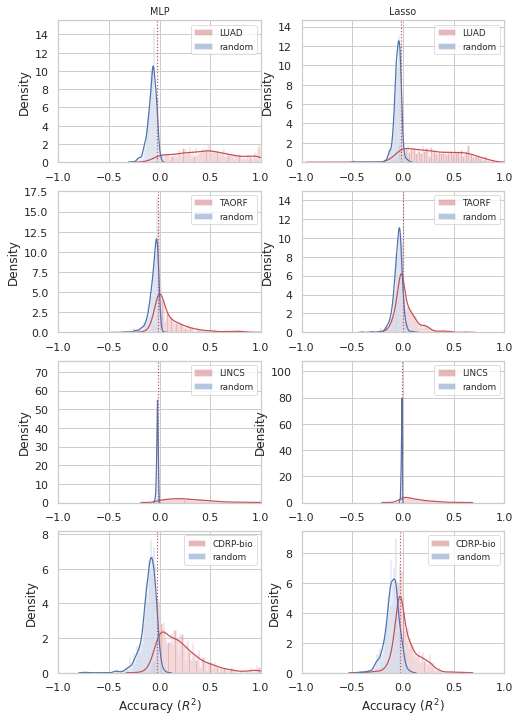

In [1072]:
filename = results_dir + "/SingleGenePred/scores_hyperParam.xlsx"
saved_scores = pd.read_excel(filename, sheet_name=None)
saved_scores.keys()

################################################
# dataset options: 'CDRP' , 'LUAD', 'TAORF', 'LINCS', 'CDRP-bio'
datasets = ["LUAD", "TAORF", "LINCS", "CDRP-bio"]
# datasets=['LUAD', 'TAORF', 'LINCS', 'CDRP-bio','CDRP'];

DT_kfold = {"LUAD": 9, "TAORF": 5, "LINCS": 25, "CDRP-bio": 6, "CDRP": 40}

################################################
# CP Profile Type options: 'augmented' , 'normalized', 'normalized_variable_selected'
profileType = "normalized_variable_selected"
profTypeAbbrev = "".join([s[0] for s in profileType.split("_")])

################################################
# filtering to compounds which have high replicates for both GE and CP datasets
highRepOverlapEnabled = 1


################################################
pertColName = "PERT"
profileLevel = "treatment"
#'replicate'  or  'treatment'
if highRepOverlapEnabled:
    f = "filt"
else:
    f = ""

models = ["MLP", "Lasso"]

DataPredResults = pd.DataFrame(columns=["Dataset", "Model"])

fig, axes = plt.subplots(
    len(datasets), len(models), figsize=(4 * len(models), 3 * len(datasets))
)
sns.set_context("paper")
sns.set_style("whitegrid")
# sns.rcParams['patch.force_edgecolor'] = True
# for d in range(5):#(len(datasets)):
for d in range(len(datasets)):
    for m in range(len(models)):

        if datasets[d] == "TAORF" or datasets[d] == "CDRP":
            f = ""
        else:
            f = "filt"

        k_fold = DT_kfold[datasets[d]]
        sheetName = (
            models[m]
            + "-"
            + datasets[d]
            + "-"
            + profTypeAbbrev
            + "-"
            + f
            + "-"
            + str(k_fold)
            + "-ht"
        )

        res_sheet = saved_scores[sheetName]

        d_to_pl = res_sheet.groupby(["lmGens", "d"]).median().reset_index()
        d_to_pl_2 = d_to_pl.copy()

        #         d_to_pl_2=res_sheet.copy()

        d_to_pl_2["Dataset"] = datasets[d]
        d_to_pl_2["Model"] = models[m]

        # axes=sns.displot(data=d_to_pl, x="pred score", hue="d")
        #     sns.distplot(saved_scores['Lasso-'+datasets[d]+filter_status[d]].pred_score.values,kde=True,hist=True,bins=100,label=datasets[d],ax=axes,norm_hist=True);
        pred_scoress = d_to_pl[d_to_pl["d"] == "n-folds"]["pred score"].values
        #         pred_scoress=res_sheet[res_sheet['d']=='n-folds']["pred score"].values
        rand_scoress = d_to_pl[d_to_pl["d"] == "random"]["pred score"].values
        #         rand_scoress=res_sheet[res_sheet['d']=='random']["pred score"].values
        sns.distplot(
            pred_scoress,
            kde=True,
            hist=True,
            bins=100,
            label=datasets[d],
            ax=axes[d, m],
            norm_hist=True,
            color="r",
        )
        sns.distplot(
            rand_scoress,
            kde=True,
            hist=True,
            bins=100,
            label="random",
            ax=axes[d, m],
            norm_hist=True,
        )
        rand99th = np.percentile(rand_scoress, 99)
        print(rand99th)

        d_to_pl_2["rand99th"] = rand99th
        DataPredResults = DataPredResults.append(d_to_pl_2)

        axes[d, 0].set_xlim(-1, 1)
        axes[d, 1].set_xlim(-1, 1)
        #         axes[d,1].set_xlim(-.5,.5)
        #         axes[d,m].set_xlim(-0.5,0.6)
        #         axes[d,m].set_ylim(0,15)
        axes[d, m].axvline(x=np.percentile(rand_scoress, 90), linestyle=":", color="r")
        axes[len(datasets) - 1, m].set_xlabel("Accuracy ($R^2$)")
        axes[d, m].legend()
        axes[0, m].set_title(models[m])

DataPredResults.loc[DataPredResults["d"] == "random", "Model"] = (
    DataPredResults[DataPredResults["d"] == "random"]["Model"]
    + "-"
    + DataPredResults[DataPredResults["d"] == "random"]["d"]
)


In [48]:
# d_to_pl_2

## Single gene prediction barplot for each dataset and each model
- Figeure 2a

In [743]:
# DataPredResults
import matplotlib.style as style

style.use("seaborn-colorblind")
sns.set_context(
    "paper",
    font_scale=2,
    rc={"font.size": 20, "axes.titlesize": 8, "axes.labelsize": 10},
)

# DataPredResults.loc[DataPredResults['d']=='random','Model']=DataPredResults[DataPredResults['d']=='random']['Model']+'-'+DataPredResults[DataPredResults['d']=='random']['d']
plt.figure(figsize=(13, 4))

# plt.rcParams["axes.labelsize"] = 40
sns.set_theme(style="whitegrid")
ax = sns.boxplot(
    x="Dataset",
    y="pred score",
    hue="Model",
    data=DataPredResults,
    order=["TAORF", "CDRP-bio", "LINCS", "LUAD"],
    hue_order=["Lasso-random", "Lasso", "MLP-random", "MLP"],
)
ax.set_ylim(-0.5, 1)
ax.set_ylabel("Accuracy ($R^2$)", fontweight="bold")
# fontsize=14,
ax.axhline(y=0, linestyle=":", color="k")
plt.tight_layout()
plt.legend(bbox_to_anchor=(1, 0.65), loc="upper left", borderaxespad=0)
plt.tight_layout()
# plt.savefig('pred_gen_all_models2.eps')

<IPython.core.display.Javascript object>

In [77]:
# meta=pd.read_csv("/home/ubuntu/bucket/projects/2018_04_20_Rosetta/workspace/metadata/affy_probe_gene_mapping.txt",delimiter="\t",header=None, names=["probe_id", "gene"])
# meta
#         meta_gene_probID=meta.set_index('probe_id')
#         d = dict(zip(meta_gene_probID.index, meta_gene_probID['gene']))

In [78]:
union_geneSymbols_1170 = DataPredResults.lmGens.unique()

textfile = open("union_geneSymbols_1170.txt", "w")
for element in union_geneSymbols_1170:
    textfile.write(element + "\n")
textfile.close()

# meta[meta['gene'].isin(union_geneSymbols_1170)]['probe_id'].unique().shape

## Single gene prediction table
- Figure 2b

In [72]:
meta.probe_id.unique().shape, meta.gene.unique().shape


((502325,), (151047,))

In [744]:
DataPredResults2 = DataPredResults.loc[DataPredResults["d"] != "random"].reset_index(
    drop=True
)
DataPredResults2[
    DataPredResults2["pred score"] > DataPredResults2["rand99th"] + 0.2
].groupby(["Dataset", "Model"]).size() * 100 / 978


Dataset   Model
CDRP-bio  Lasso     7.873211
          MLP      38.445808
LINCS     Lasso    23.210634
          MLP      60.429448
LUAD      Lasso    56.952965
          MLP      77.505112
TAORF     Lasso     4.601227
          MLP      17.791411
dtype: float64

In [745]:
DataPredResults2 = DataPredResults.loc[DataPredResults["d"] != "random"].reset_index(
    drop=True
)
DataPredResults2[
    DataPredResults2["pred score"] > DataPredResults2["rand99th"] + 0.2
].groupby(["Dataset", "Model"]).size()


Dataset   Model
CDRP-bio  Lasso     77
          MLP      376
LINCS     Lasso    227
          MLP      591
LUAD      Lasso    557
          MLP      758
TAORF     Lasso     45
          MLP      174
dtype: int64

## Venn diagram of the highly predictable genes across datasets - MLP model
- Figure 2c

In [747]:
DataPredRes4venn = DataPredResults2[
    DataPredResults2["pred score"] > DataPredResults2["rand99th"] + 0.2
]
DataPredRes4venn = DataPredRes4venn[DataPredRes4venn["Model"] == "MLP"].reset_index(
    drop=True
)
DataPredRes4venn["hp-scores"] = DataPredRes4venn["pred score"] - (
    DataPredRes4venn["rand99th"] + 0.2
)
# DataPredRes4venn

from venn import venn

list_4_ven = {}
dsets = ["CDRP-bio", "LINCS", "LUAD", "TAORF"]
set_lab = tuple(dsets)
# plt.figure()
for d in dsets:
    list_4_ven[d] = set(DataPredRes4venn[DataPredRes4venn["Dataset"] == d].lmGens)

# venn(list_4_ven,legend_loc='upper center')
venn(list_4_ven, legend_loc="lower right")
# plt.tight_layout()
# plt.savefig('pred_gen_venn.eps')

<IPython.core.display.Javascript object>

In [63]:
DataPredResults

,Dataset,Model,lmGens,d,Unnamed: 0.1,Unnamed: 0,pred score,rand99th
0,LUAD,MLP,AARS,n-folds,4.0,4.0,0.964530,0.002805
1,LUAD,MLP-random,AARS,random,8806.0,8806.0,-0.073072,0.002805
2,LUAD,MLP,ABCB6,n-folds,13.0,13.0,0.994643,0.002805
3,LUAD,MLP-random,ABCB6,random,8815.0,8815.0,-0.124197,0.002805
4,LUAD,MLP,ABCC5,n-folds,22.0,22.0,-0.010185,0.002805
...,...,...,...,...,...,...,...,...
1949,CDRP-bio,Lasso-random,ZNF692,random,11636.5,11636.5,-0.165209,0.025695
1950,CDRP-bio,Lasso,ZNF768,n-folds,284.5,284.5,-0.028835,0.025695
1951,CDRP-bio,Lasso-random,ZNF768,random,6146.5,6146.5,-0.120603,0.025695
1952,CDRP-bio,Lasso,ZW10,n-folds,3974.5,3974.5,0.090981,0.025695


In [748]:
with pd.option_context(
    "display.max_rows", None, "display.max_columns", None
):  # more options can be specified also
    print(DataPredRes4venn.groupby("lmGens").size().reset_index())


In [62]:
DataPredRes4venn

,Dataset,Model,lmGens,d,Unnamed: 0.1,Unnamed: 0,pred score,rand99th,hp-scores
0,LUAD,MLP,AARS,n-folds,4.0,4.0,0.964530,0.002805,0.761725
1,LUAD,MLP,ABCB6,n-folds,13.0,13.0,0.994643,0.002805,0.791839
2,LUAD,MLP,ABCF3,n-folds,40.0,40.0,0.477182,0.002805,0.274378
3,LUAD,MLP,ABHD4,n-folds,49.0,49.0,0.932880,0.002805,0.730076
4,LUAD,MLP,ABHD6///LOC643635,n-folds,58.0,58.0,0.338941,0.002805,0.136137
...,...,...,...,...,...,...,...,...,...
1894,CDRP-bio,MLP,ZNF318,n-folds,2864.5,2864.5,0.245341,0.014306,0.031035
1895,CDRP-bio,MLP,ZNF451,n-folds,2084.5,2084.5,0.495832,0.014306,0.281526
1896,CDRP-bio,MLP,ZNF586,n-folds,1676.5,1676.5,0.240693,0.014306,0.026387
1897,CDRP-bio,MLP,ZNF672,n-folds,272.5,272.5,0.275842,0.014306,0.061536


In [76]:
top_58_overlappingGenes = (
    DataPredRes4venn.groupby("lmGens")
    .size()[list(DataPredRes4venn.groupby("lmGens").size() > 3)]
    .index.to_list()
)

textfile = open("top_58_common.txt", "w")
for element in top_58_overlappingGenes:
    textfile.write(element + "\n")
textfile.close()

In [48]:
len(list(DataPredRes4venn.groupby("lmGens").size() > 3))


921

## Explore gene family of top genes in LUAD ( $R^2$>0.9) 
- Using hgnc_gene_group_family_dictionary

- Supplementary Figure 4

In [1094]:
# top 58 overlap in all datasets
"""
topInAll=DataPredRes4venn.groupby(['lmGens','Dataset']).size().reset_index().groupby(['lmGens']).size().reset_index()
top58=topInAll[topInAll[0]>3].lmGens.tolist()
"""
# top 20 in LUAD - First version
# top58=DataPredResults2[DataPredResults2["Dataset"]=="LUAD"].sort_values(by="pred score")[-20:]['lmGens'].tolist()

# Revision version
top_LUAD = (
    DataPredResults[
        (DataPredResults["Dataset"] == "LUAD") & (DataPredResults["Model"] == "MLP")
    ]
    .reset_index(drop=True)
    .sort_values(by="pred score", ascending=False)
    .reset_index(drop=True)
)
top_luad_list = top_LUAD[top_LUAD["pred score"] > 0.9]["lmGens"].tolist()


In [52]:
# top58=DataPredResults2[DataPredResults2["Dataset"]=="LUAD"].sort_values(by="pred score")[-20:]['lmGens'].tolist()
# top58
# DataPredResults2[DataPredResults2["Dataset"]=="LUAD"].sort_values(by="pred score")[-20:]

In [1095]:
meta_geneFamily = pd.read_csv(
    "/home/ubuntu/bucket/projects/2018_04_20_Rosetta/workspace/metadata/hgnc_gene_group_family_dictionary.csv"
)
# genesU = meta_geneFamily.approved_symbol.unique().tolist()
# meta_geneFamilyU=pd.DataFrame(index=range(len(genesU)),columns=["lmGens","gene_group_name"])

meta_geneFamily_top = meta_geneFamily[
    meta_geneFamily["approved_symbol"].isin(top_luad_list)
].reset_index(drop=True)
meta_top = (
    meta_geneFamily_top.groupby(["gene_group_name"])
    .size()
    .sort_values(ascending=False)
    .reset_index()
)


In [1132]:
# meta_geneFamily_top[meta_geneFamily_top['gene_group_name'].isin(meta_top.gene_group_name.tolist())]
# meta_geneFamily_top.groupby(['gene_group_name','approved_symbol']).size().sort_values(by=ascending=False)
# meta_geneFamily_top.groupby(['gene_group_name']).size()
top_groups = meta_top.gene_group_name.tolist()
for t in top_groups:
    meta_top.loc[meta_top["gene_group_name"] == t, "Genes"] = ",".join(
        meta_geneFamily_top.loc[
            meta_geneFamily_top["gene_group_name"] == t, "approved_symbol"
        ].tolist()
    )


In [1134]:
print(meta_top[["gene_group_name", "Genes"]].to_latex(index=False))


\begin{tabular}{ll}
\toprule
                                   gene\_group\_name &             Genes \\
\midrule
                                  Receptor ligands & C5,MMP1,RGS2,SPP1 \\
                MicroRNA protein coding host genes &   ERBB2,GPC1,SMC4 \\
                                           Cyclins &       CCNA2,CCND3 \\
                       WD repeat domain containing &        COPB2,GNB5 \\
                     Basic leucine zipper proteins &       CEBPA,CEBPD \\
                             LIM domain containing &          FHL2,PXN \\
                   CCAAT/enhancer binding proteins &       CEBPA,CEBPD \\
                         EF-hand domain containing &         CALU,MYL9 \\
                                         Collagens &     COL1A1,COL4A1 \\
                                            SNAREs &       SNAP25,YKT6 \\
   Short chain dehydrogenase/reductase superfamily &         CBR3,GALE \\
                                 Chemokine ligands &        CCL2,CXCL2 \

/tmp/ipykernel_64355/1819400956.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(meta_top[['gene_group_name','Genes']].to_latex(index=False))


In [1115]:
# meta_geneFamily[meta_geneFamily['approved_symbol'].isin(top58)].shape
# meta_top
# meta_geneFamily_top
meta_geneFamily_top.groupby(["gene_group_name", "approved_symbol"]).size()


gene_group_name                    approved_symbol
ATP binding cassette subfamily B   ABCB6              1
Abhydrolase domain containing      ABHD4              1
Ankyrin repeat domain containing   ILK                1
BCL2 homology region 3 (BH3) only  BNIP3              1
Baculoviral IAP repeat containing  BIRC5              1
                                                     ..
Tropomyosins                       TPM1               1
WD repeat domain containing        COPB2              1
                                   GNB5               1
YIP family                         PRAF2              1
Zinc fingers ZZ-type               SQSTM1             1
Length: 90, dtype: int64

In [1099]:
from matplotlib.cm import get_cmap

name = "tab20"
cmap = get_cmap(name, 10)  # type: matplotlib.colors.ListedColormap
# colors =
cmap.colors
# len(labels)

array([[0.12156863, 0.46666667, 0.70588235, 1.        ],
       [1.        , 0.49803922, 0.05490196, 1.        ],
       [0.17254902, 0.62745098, 0.17254902, 1.        ],
       [0.83921569, 0.15294118, 0.15686275, 1.        ],
       [0.58039216, 0.40392157, 0.74117647, 1.        ],
       [0.76862745, 0.61176471, 0.58039216, 1.        ],
       [0.96862745, 0.71372549, 0.82352941, 1.        ],
       [0.78039216, 0.78039216, 0.78039216, 1.        ],
       [0.85882353, 0.85882353, 0.55294118, 1.        ],
       [0.61960784, 0.85490196, 0.89803922, 1.        ]])

/tmp/ipykernel_64355/1153179714.py:19: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


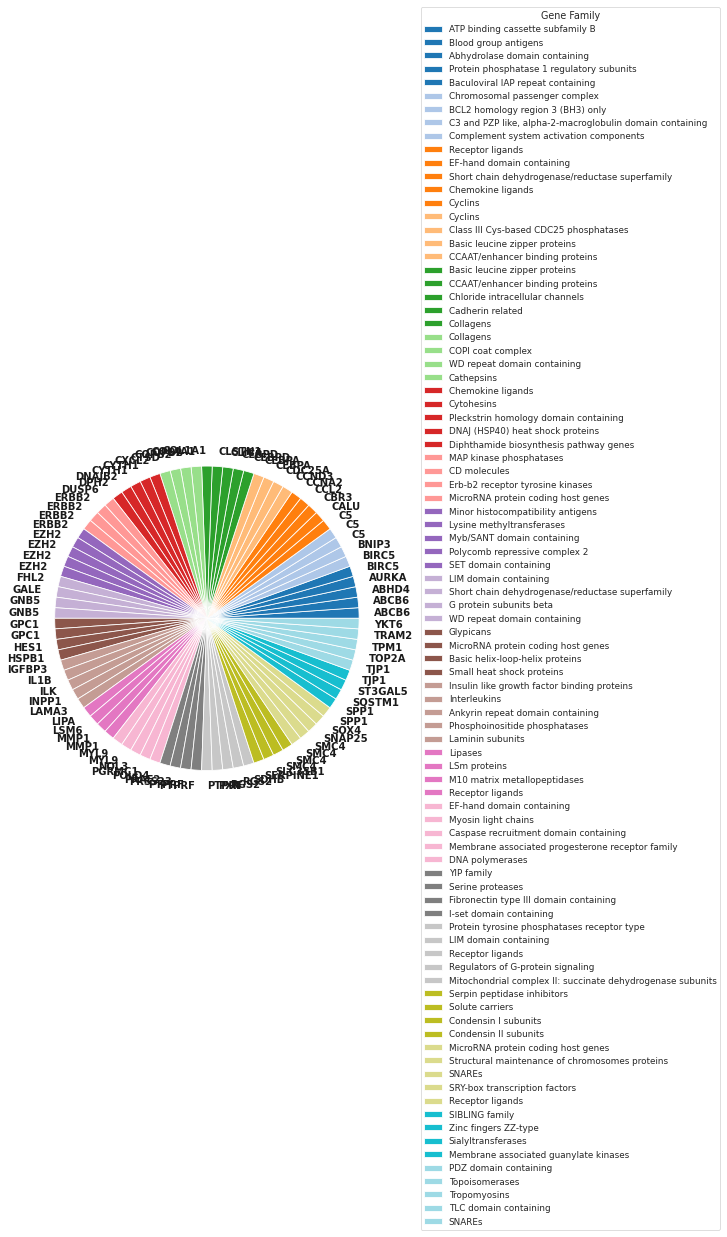

In [1100]:
fig, ax = plt.subplots(figsize=(8, 7), subplot_kw=dict(aspect="equal"))

labels = meta_geneFamily_top["approved_symbol"].to_list()
ingredients = meta_geneFamily_top["gene_group_name"].to_list()
data = np.ones(
    meta_geneFamily_top["gene_group_name"].shape[0],
)


wedges, autotexts = ax.pie(
    data,
    labels=labels,
    colors=get_cmap(
        "tab20", len(labels)
    ).colors,  # autopct=lambda pct: func(pct,meta_geneFamily_top),
    textprops=dict(color="k"),
)

ax.legend(
    wedges,
    ingredients,
    title="Gene Family",
    loc="center left",
    bbox_to_anchor=(1.05, 0, 0.5, 1),
)

plt.setp(autotexts, size=10, weight="bold")

# ax.set_title("LUAD top genes")
plt.tight_layout()
plt.show()

In [1102]:
meta_geneFamily_top["approved_symbol"].shape


(90,)

In [23]:
# wedges

## Supp Table of prediction scores for each of the MLP and Lasso models 
- Supplementary D

In [751]:
unq_lmgenes = DataPredResults2["lmGens"].unique()

d_luad = DataPredResults2[DataPredResults2["Dataset"] == "LUAD"].reset_index(drop=True)
d_cdrpbio = DataPredResults2[DataPredResults2["Dataset"] == "CDRP-bio"].reset_index(
    drop=True
)
d_lincs = DataPredResults2[DataPredResults2["Dataset"] == "LINCS"].reset_index(
    drop=True
)
d_taorf = DataPredResults2[DataPredResults2["Dataset"] == "TAORF"].reset_index(
    drop=True
)

# unq_lmgenes

In [28]:
cols = [
    "CDRP-bio-Lasso",
    "CDRP-bio-MLP",
    "LUAD-Lasso",
    "LUAD-MLP",
    "LINCS-Lasso",
    "LINCS-MLP",
    "TAORF-Lasso",
    "TAORF-MLP",
]
DataAppendix = pd.DataFrame(index=unq_lmgenes, columns=cols)

for ds in ["LUAD", "TAORF", "LINCS", "CDRP-bio"]:
    for m in ["Lasso", "MLP"]:
        d_luad = DataPredResults2[DataPredResults2["Dataset"] == ds].reset_index(
            drop=True
        )
        d_luad2 = d_luad[(d_luad["Model"] == m)]
        DataAppendix.loc[d_luad2["lmGens"].values, ds + "-" + m] = d_luad2[
            "pred score"
        ].values
DataAppendix[cols] = DataAppendix[cols] * 100
DataAppendix[cols] = DataAppendix[cols].astype(float).round(2)


In [33]:
DataAppendix.to_csv(results_dir + "/SingleGenePred/Appendix_D.csv")


In [34]:
# DataAppendix#.to_markdown()

In [226]:
# DataAppendix.loc[unq_lmgenes.tolist()]

In [248]:
DataAppendix.shape

# DataAppendix[unq_lmgenes,"LUAD-MLP"]=d_luad[(d_luad["lmGens"].isin(unq_lmgenes))&(d_luad["Model"]=='MLP')]["pred score"]

(1170, 8)

In [249]:
# DataAppendix[(d_luad["lmGens"].isin(unq_lmgenes))]
# DataAppendix
# d_luad=DataPredResults2[DataPredResults2['Dataset']=='LUAD'].reset_index(drop=True)
# DataAppendix[0:60]
range(0, 60 * 20, 60)


range(0, 1200, 60)

In [252]:
# d_luad["lmGens"]
# DataAppendix.loc[d_luad["lmGens"].values]
for i in range(0, 55 * 20, 55):
    print("\\begin{table}")
    print(DataAppendix[i : i + 55].to_latex(index=True))
    print("\end{table}")

In [40]:
# DataPredResults

## Supplementary C - Top 50 GE using MLP
- Supplementary C (Supplementary Figure 2.)

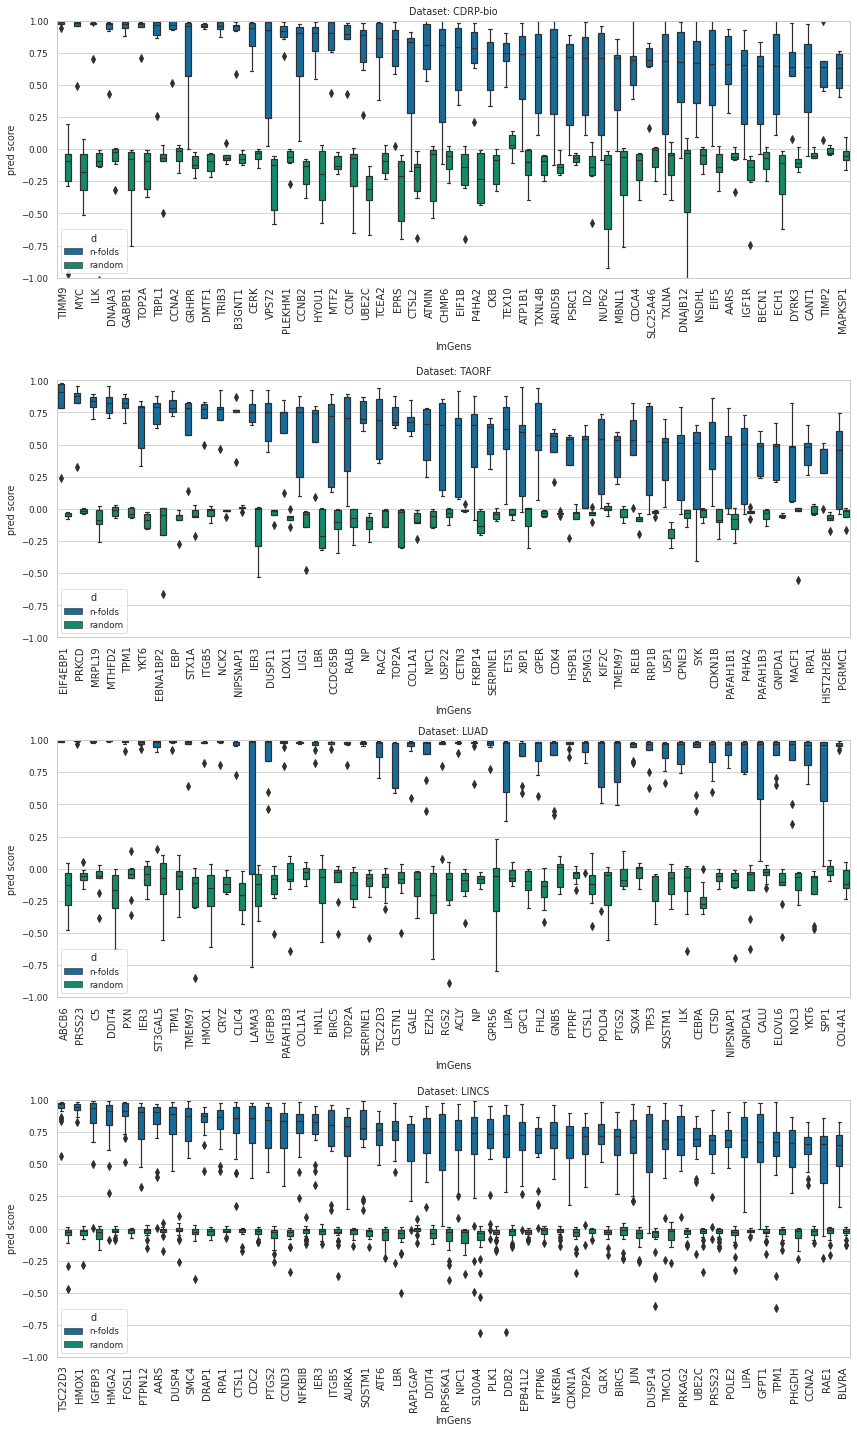

In [52]:
datasets = ["CDRP-bio", "TAORF", "LUAD", "LINCS"]
models = ["MLP"]
f = "-filt"
#'-filt'

fig, axes = plt.subplots(len(datasets), 1, figsize=(12, 20))
sns.set_context("paper")
sns.set_style("whitegrid")
# sns.rcParams['patch.force_edgecolor'] = True
# for d in range(5):#(len(datasets)):
for d in range(len(datasets)):
    for m in range(len(models)):
        dataset_meth_dists = DataPredResults[
            (DataPredResults["Dataset"] == datasets[d])
            & (DataPredResults["Model"] == models[m])
        ]
        sorted_gene_mean_scores = (
            dataset_meth_dists[dataset_meth_dists["d"] == "n-folds"]
            .groupby(["lmGens", "d"])
            .median()
            .reset_index()
            .sort_values(by=["pred score"], ascending=False)
        )
        top_lmGenes = sorted_gene_mean_scores["lmGens"].tolist()[0:50]
        dataset_meth_dists_top_50 = dataset_meth_dists[
            dataset_meth_dists["lmGens"].isin(top_lmGenes)
        ]

        #         f, axes = plt.subplots(figsize=(15,4))
        axes[d].set_title("Dataset: " + datasets[d])
        sns.boxplot(
            x="lmGens",
            y="pred score",
            hue="d",
            data=dataset_meth_dists_top_50,
            ax=axes[d],
            order=top_lmGenes,
        )
        # ax = sns.violinplot(x="lmGens", y="pred score", hue="d",data=tips2, palette="muted", split=True)
        axes[d].set_xticklabels(axes[d].get_xticklabels(), rotation=90, fontsize=10)
        axes[d].set_ylim(-1, 1)

fig.tight_layout()
# fig.savefig('appendix_B.eps')

## single GE cross datasets prediction results (LUAD and LINCS)
- Supplementary F. Supplementary Figure 4.

In [79]:
filename = results_dir + "/SingleGenePred/scores_cross_dts_LU_LI.xlsx"
saved_scores = pd.read_excel(filename, sheet_name=None)
saved_scores.keys()
# saved_scores


dict_keys(['Lasso-n-filt-ht', 'Ridge-nvs-filt-ht', 'Lasso-nvsu-filt-ht', 'MLP-nvsu-filt-ht', 'MLP-n-filt-ht', 'Ridge-n-filt-ht', 'Ridge-nvsu-filt-ht'])

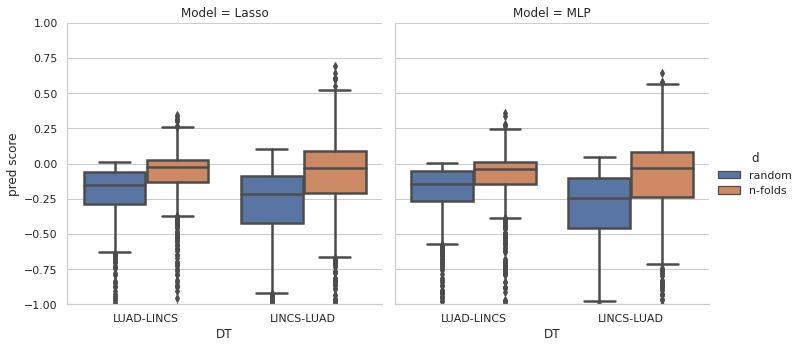

In [80]:
filename = results_dir + "/SingleGenePred/scores_cross_dts_LU_LI.xlsx"
saved_scores = pd.read_excel(filename, sheet_name=None)
saved_scores.keys()

DataPredResults.loc[DataPredResults["d"] == "random", "Model"] = (
    DataPredResults[DataPredResults["d"] == "random"]["Model"]
    + "-"
    + DataPredResults[DataPredResults["d"] == "random"]["d"]
)

scores_l = saved_scores["Lasso-nvsu-filt-ht"]
scores_l["Model"] = "Lasso"

scores_r = saved_scores["Ridge-nvs-filt-ht"]
scores_r["Model"] = "Ridge"

scores_m = saved_scores["MLP-nvsu-filt-ht"]
scores_m["Model"] = "MLP"

# scores=pd.concat([scores_l,scores_r,scores_m])
scores = pd.concat([scores_l, scores_m])

ax = sns.catplot(
    x="DT",
    y="pred score",
    hue="d",
    col="Model",
    kind="box",
    hue_order=["random", "n-folds"],
    data=scores,
    linewidth=2.5,
)
# ax.set_ylim(-1,1);
ax.set(ylim=(-1, 1))

In [94]:
scores_r

,Unnamed: 0,DT,lmGens,pred score,Model
0,0,LUAD-LINCS,CD58,-19.641415,Ridge
1,1,LINCS-LUAD,CD58,-17.812568,Ridge
2,2,LUAD-LINCS,HMGCR,-5.336091,Ridge
3,3,LINCS-LUAD,HMGCR,-9.002684,Ridge
4,4,LUAD-LINCS,BLMH,-14.042498,Ridge
...,...,...,...,...,...
1951,1951,LINCS-LUAD,GADD45B,-9.101124,Ridge
1952,1952,LUAD-LINCS,PRR7,-13.269691,Ridge
1953,1953,LINCS-LUAD,PRR7,-5.435615,Ridge
1954,1954,LUAD-LINCS,WFS1,-6.373452,Ridge


In [4]:
filename = results_dir + "/SingleGenePred/scores_cross_dts_CD_LI.xlsx"
saved_scores = pd.read_excel(filename, sheet_name=None)
saved_scores.keys()

dict_keys(['MLP-nvsu-filt-ht', 'Lasso-nvsu-filt-ht'])

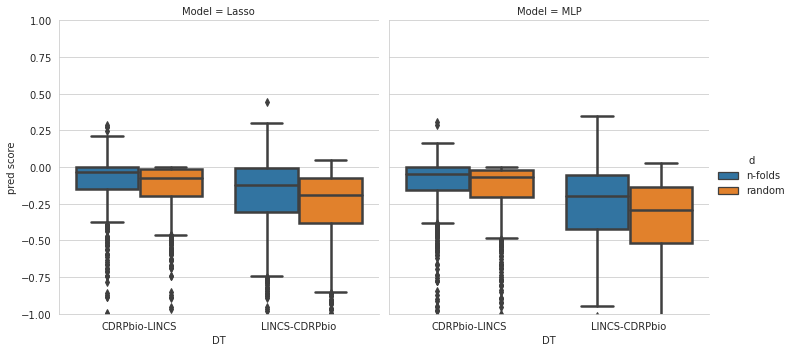

In [6]:
# DataPredResults.loc[DataPredResults['d']=='random','Model']=DataPredResults[DataPredResults['d']=='random']['Model']+'-'+DataPredResults[DataPredResults['d']=='random']['d']

scores_l = saved_scores["Lasso-nvsu-filt-ht"]
scores_l["Model"] = "Lasso"

# scores_r=saved_scores['Ridge-nvs-filt-ht']
# scores_r['Model']='Ridge'

scores_m = saved_scores["MLP-nvsu-filt-ht"]
scores_m["Model"] = "MLP"

# scores=pd.concat([scores_l,scores_r,scores_m])
scores = pd.concat([scores_l, scores_m])

ax = sns.catplot(
    x="DT", y="pred score", hue="d", col="Model", kind="box", data=scores, linewidth=2.5
)
# ax.set_ylim(-1,1);
ax.set(ylim=(-1, 1))

## Read single CP feature prediction results
- Figure 3a

In [526]:
filename = results_dir + "/SingleCPfeatPred/scores_hyperParam.xlsx"
saved_scores = pd.read_excel(filename, sheet_name=None)
saved_scores.keys()

dict_keys(['Lasso-TAORF-n--7-ht', 'Lasso-TAORF-n--5-ht', 'MLP-TAORF-n--5-ht', 'Lasso-LUAD-n-filt-9-ht', 'MLP-LUAD-n-filt-9-ht', 'Lasso-LINCS-n-filt-25-ht', 'Lasso-CDRP-n--40-ht', 'MLP-LINCS-n-filt-25-ht', 'Lasso-CDRP-bio-n-filt-6-ht', 'MLP-CDRP-bio-n-filt-6-ht'])

In [525]:
filename = results_dir + "/SingleCPfeatPred/scores.xlsx"
saved_scores = pd.read_excel(filename, sheet_name=None)
saved_scores.keys()

dict_keys(['Lasso-LUAD-n-filt-10-ht', 'MLP-LUAD-n-filt-10-ht', 'Lasso-TAORF-n-filt-10-ht'])

In [ ]:
saved_scores

In [527]:
################################################
# dataset options: 'CDRP' , 'LUAD', 'TAORF', 'LINCS', 'CDRP-bio'
datasets = ["LUAD", "TAORF", "LINCS", "CDRP-bio"]
# datasets=['LUAD', 'TAORF', 'LINCS', 'CDRP-bio','CDRP'];

DT_kfold = {"LUAD": 9, "TAORF": 5, "LINCS": 25, "CDRP-bio": 6, "CDRP": 40}

################################################
# CP Profile Type options: 'augmented' , 'normalized', 'normalized_variable_selected'
profileType = "normalized"
profTypeAbbrev = "".join([s[0] for s in profileType.split("_")])

################################################
# filtering to compounds which have high replicates for both GE and CP datasets
highRepOverlapEnabled = 1


################################################
pertColName = "PERT"
profileLevel = "treatment"
#'replicate'  or  'treatment'
if highRepOverlapEnabled:
    f = "filt"
else:
    f = ""

models = ["MLP", "Lasso"]

DataPredResults = pd.DataFrame(columns=["Dataset", "Model"])

fig, axes = plt.subplots(
    len(datasets), len(models), figsize=(4 * len(models), 3 * len(datasets))
)
sns.set_context("paper")
sns.set_style("whitegrid")
# sns.rcParams['patch.force_edgecolor'] = True
# for d in range(5):#(len(datasets)):
for d in range(len(datasets)):
    for m in range(len(models)):

        if datasets[d] == "TAORF" or datasets[d] == "CDRP":
            f = ""
        else:
            f = "filt"

        k_fold = DT_kfold[datasets[d]]
        sheetName = (
            models[m]
            + "-"
            + datasets[d]
            + "-"
            + profTypeAbbrev
            + "-"
            + f
            + "-"
            + str(k_fold)
            + "-ht"
        )

        res_sheet = saved_scores[sheetName]
        #         d_to_pl_2=res_sheet.copy()

        d_to_pl = res_sheet.groupby(["CP-Features", "d"]).median().reset_index()
        d_to_pl_2 = d_to_pl.copy()

        d_to_pl_2["Dataset"] = datasets[d]
        d_to_pl_2["Model"] = models[m]

        # axes=sns.displot(data=d_to_pl, x="pred score", hue="d")
        #     sns.distplot(saved_scores['Lasso-'+datasets[d]+filter_status[d]].pred_score.values,kde=True,hist=True,bins=100,label=datasets[d],ax=axes,norm_hist=True);
        pred_scoress = d_to_pl[d_to_pl["d"] == "n-folds"]["pred score"].values
        #         pred_scoress=res_sheet[res_sheet['d']=='n-folds']["pred score"].values
        rand_scoress = d_to_pl[d_to_pl["d"] == "random"]["pred score"].values
        #         rand_scoress=res_sheet[res_sheet['d']=='random']["pred score"].values
        sns.distplot(
            pred_scoress,
            kde=True,
            hist=True,
            bins=100,
            label=datasets[d],
            ax=axes[d, m],
            norm_hist=True,
            color="r",
        )
        sns.distplot(
            rand_scoress,
            kde=True,
            hist=True,
            bins=100,
            label="random",
            ax=axes[d, m],
            norm_hist=True,
        )
        rand99th = np.percentile(rand_scoress, 99)
        print(rand99th)

        d_to_pl_2["rand99th"] = rand99th
        DataPredResults = DataPredResults.append(d_to_pl_2)

        axes[d, 0].set_xlim(-1, 1)
        axes[d, 1].set_xlim(-1, 1)
        #         axes[d,1].set_xlim(-.5,.5)
        #         axes[d,m].set_xlim(-0.5,0.6)
        #         axes[d,m].set_ylim(0,15)
        axes[d, m].axvline(x=np.percentile(rand_scoress, 90), linestyle=":", color="r")
        axes[len(datasets) - 1, m].set_xlabel("Accuracy ($R^2$)")
        axes[d, m].legend()
        axes[0, m].set_title(models[m])

DataPredResults.loc[DataPredResults["d"] == "random", "Model"] = (
    DataPredResults[DataPredResults["d"] == "random"]["Model"]
    + "-"
    + DataPredResults[DataPredResults["d"] == "random"]["d"]
)


<IPython.core.display.Javascript object>

/home/ubuntu/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ubuntu/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


-0.19603887603590917


/tmp/ipykernel_64355/386374391.py:70: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  DataPredResults=DataPredResults.append(d_to_pl_2)
/home/ubuntu/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ubuntu/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


0.028074065467007712


/tmp/ipykernel_64355/386374391.py:70: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  DataPredResults=DataPredResults.append(d_to_pl_2)
/home/ubuntu/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ubuntu/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


-0.1285110183629015


/tmp/ipykernel_64355/386374391.py:70: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  DataPredResults=DataPredResults.append(d_to_pl_2)
/home/ubuntu/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ubuntu/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


0.05268358301618449


/tmp/ipykernel_64355/386374391.py:70: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  DataPredResults=DataPredResults.append(d_to_pl_2)
/home/ubuntu/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ubuntu/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


-0.9683046999579288


/tmp/ipykernel_64355/386374391.py:70: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  DataPredResults=DataPredResults.append(d_to_pl_2)
/home/ubuntu/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ubuntu/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


-0.0030023651933078687


/tmp/ipykernel_64355/386374391.py:70: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  DataPredResults=DataPredResults.append(d_to_pl_2)
/home/ubuntu/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ubuntu/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


-0.185286786655459


/tmp/ipykernel_64355/386374391.py:70: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  DataPredResults=DataPredResults.append(d_to_pl_2)
/home/ubuntu/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ubuntu/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/tmp/ipykernel_64355/386374391.py:70: FutureWarning

0.031259361243711856


In [528]:
# DataPredResults
import matplotlib.style as style

style.use("seaborn-colorblind")
sns.set_context(
    "paper",
    font_scale=2,
    rc={"font.size": 20, "axes.titlesize": 8, "axes.labelsize": 10},
)

# DataPredResults.loc[DataPredResults['d']=='random','Model']=DataPredResults[DataPredResults['d']=='random']['Model']+'-'+DataPredResults[DataPredResults['d']=='random']['d']
plt.figure(figsize=(13, 4))

# plt.rcParams["axes.labelsize"] = 40
sns.set_theme(style="whitegrid")
ax = sns.boxplot(
    x="Dataset",
    y="pred score",
    hue="Model",
    data=DataPredResults,
    order=["TAORF", "CDRP-bio", "LINCS", "LUAD"],
    hue_order=["Lasso-random", "Lasso", "MLP-random", "MLP"],
)
ax.set_ylim(-0.5, 1)
ax.set_ylabel("Accuracy ($R^2$)", fontweight="bold")
# fontsize=14,
ax.axhline(y=0, linestyle=":", color="k")
plt.tight_layout()
plt.legend(bbox_to_anchor=(1, 0.65), loc="upper left", borderaxespad=0)
plt.tight_layout()
# plt.savefig('pred_gen_all_models2.eps')

<IPython.core.display.Javascript object>

In [529]:
DataPredResults_fPlot = DataPredResults[
    (DataPredResults["d"] != "random") & (DataPredResults["Model"] == "MLP")
].reset_index(drop=True)
# DataPredResults
import matplotlib.style as style

style.use("seaborn-colorblind")
sns.set_context(
    "paper",
    font_scale=2,
    rc={"font.size": 20, "axes.titlesize": 8, "axes.labelsize": 10},
)

# DataPredResults.loc[DataPredResults['d']=='random','Model']=DataPredResults[DataPredResults['d']=='random']['Model']+'-'+DataPredResults[DataPredResults['d']=='random']['d']
plt.figure(figsize=(3, 6))

# plt.rcParams["axes.labelsize"] = 40
sns.set_theme(style="whitegrid")
ax = sns.boxplot(
    x="Dataset",
    y="pred score",
    data=DataPredResults_fPlot,
    order=["TAORF", "CDRP-bio", "LINCS", "LUAD"],
    palette="Set2",
)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_ylim(-0.5, 1.01)
ax.set_ylabel("Accuracy ($R^2$)", fontweight="bold")
# fontsize=14,
ax.axhline(y=0, linestyle=":", color="k")
plt.tight_layout()
# plt.legend(bbox_to_anchor=(1, .65), loc='upper left', borderaxespad=0)
plt.tight_layout()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


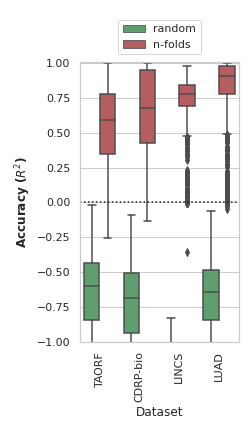

In [535]:
plt.figure(figsize=(3.5, 6))
style.use("seaborn-colorblind")
sns.set_context(
    "paper",
    font_scale=2,
    rc={"font.size": 20, "axes.titlesize": 8, "axes.labelsize": 10},
)
# plt.rcParams["axes.labelsize"] = 40
DataPredResults_fPlot_v = DataPredResults[
    DataPredResults["Model"].isin(["MLP", "MLP-random"])
].reset_index(drop=True)
my_pal = {"random": "g", "n-folds": "r"}
sns.set_theme(style="whitegrid")
ax = sns.boxplot(
    x="Dataset",
    y="pred score",
    data=DataPredResults_fPlot_v,
    hue_order=["random", "n-folds"],
    hue="d",
    order=["TAORF", "CDRP-bio", "LINCS", "LUAD"],
    palette=my_pal,
)
# ax = sns.violinplot(x="Dataset", y="pred score",hue='d',
#                     data=DataPredResults_fPlot_v, palette="muted",split=True)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_ylim(-1, 1.01)
ax.set_ylabel("Accuracy ($R^2$)", fontweight="bold")
# fontsize=14,
ax.axhline(y=0, linestyle=":", color="k")
plt.legend(bbox_to_anchor=(0.5, 1.15), loc="upper center", borderaxespad=0)
plt.tight_layout()
# plt.legend(bbox_to_anchor=(1, .65), loc='upper left', borderaxespad=0)
# plt.tight_layout()


In [112]:
DataPredResults_fPlot_v

,Dataset,Model,CP-Features,d,Unnamed: 0,pred score,rand99th


In [26]:
DataPredResults2 = DataPredResults.loc[DataPredResults["d"] != "random"].reset_index(
    drop=True
)
DataPredResults2[
    DataPredResults2["pred score"] > DataPredResults2["rand99th"] + 0.2
].groupby(["Dataset", "Model"]).size()


Dataset   Model
CDRP-bio  Lasso     894
          MLP      1527
LINCS     Lasso    1469
          MLP      1670
LUAD      Lasso    1337
          MLP      1546
TAORF     Lasso     500
          MLP      1526
dtype: int64

## CP feature cats for fs with median pred score across all datasets >0.9
- Figure 3b

In [44]:
dfRes1 = DataPredResults2[DataPredResults2["Model"] == "MLP"].reset_index(drop=True)
dfRes2 = (
    dfRes1.groupby(["CP-Features"])
    .median()
    .sort_values(by="pred score", ascending=False)
)
dfRes3 = dfRes2[dfRes2["pred score"] > 0.9]
topFeatures = dfRes3.index.tolist()
cp_featuress = dfRes2.index.tolist()
# dfRes1=DataPredResults2[DataPredResults2['Model']=='MLP'].reset_index(drop=True)

In [44]:
# Channelss[ch]

In [45]:
# topFeatures
# dfRes2.index.tolist()

In [119]:
# [s for s in topFeatures if (Channelss[ch] in s) and (featureGroups[f] in s)]

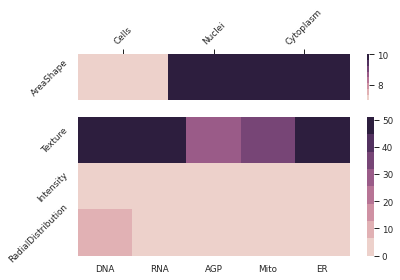

In [54]:
label2 = []
r2 = []
r2_t = []
Channelss = ["DNA", "RNA", "AGP", "Mito", "ER"]
featureGroups = ["Texture", "Intensity", "RadialDistribution"]

Mat = np.zeros((len(featureGroups), len(Channelss)))
scaler = preprocessing.StandardScaler()

for ch in range(len(Channelss)):
    for f in range(len(featureGroups)):
        freq = len(
            [s for s in topFeatures if (Channelss[ch] in s) and (featureGroups[f] in s)]
        )
        freq_t = len(
            [
                s
                for s in cp_featuress
                if (Channelss[ch] in s) and (featureGroups[f] in s)
            ]
        )

        Mat[f, ch] = freq
        if freq > 0:
            label2.append(Channelss[ch] + "-" + featureGroups[f])
            r2.append(freq)
            r2_t.append(freq_t)

fig, axes = plt.subplots(2, 1, gridspec_kw={"height_ratios": [1, 3]})
sns.heatmap(Mat, cmap=sns.cubehelix_palette(8), ax=axes[1])
axes[1].xaxis.set_ticklabels(Channelss)
axes[1].yaxis.set_ticklabels(featureGroups, rotation=360 + 45)
plt.tight_layout()

cellAreas = ["Cells", "Nuclei", "Cytoplasm"]
MatArea = np.zeros((1, len(cellAreas)))
for ca in range(len(cellAreas)):
    freq = len([s for s in topFeatures if (cellAreas[ca] in s) and ("AreaShape" in s)])
    freq_t = len(
        [s for s in cp_featuress if (cellAreas[ca] in s) and ("AreaShape" in s)]
    )

    MatArea[0, ca] = freq
    if freq > 0:
        label2.append(cellAreas[ca] + "-AreaShape")
        r2.append(freq)
        r2_t.append(freq)
#     print(MatArea)
sns.heatmap(MatArea, cmap=sns.cubehelix_palette(8), ax=axes[0])
axes[0].xaxis.tick_top()
axes[0].xaxis.set_ticklabels(cellAreas, rotation=360 + 45)
axes[0].yaxis.set_ticklabels(["AreaShape"], rotation=360 + 45)
plt.tight_layout()

# colors2=sns.color_palette("husl", len(label2))
colors2 = sns.color_palette("colorblind", len(label2))


In [524]:
r2

NameError: name 'r2' is not defined

In [57]:
# DataPredResults2[(DataPredResults2['Dataset']=='LUAD')&(DataPredResults2['CP-Features']=='Cells_AreaShape_Area')]
ratio_list2 = [(r2[i] / r2_t[i]) * 20 for i in range(len(r2))]


In [121]:
# print(DataPredResults2.groupby(['Dataset','CP-Features']).size().reset_index().to_markdown())

In [122]:
# DataPredResults2

In [ ]:
colorblind

In [155]:
# sns.color_palette("colorblind", len(label2))


In [62]:
label2

['DNA-Texture',
 'DNA-Intensity',
 'DNA-RadialDistribution',
 'RNA-Texture',
 'RNA-Intensity',
 'AGP-Texture',
 'AGP-Intensity',
 'AGP-RadialDistribution',
 'Mito-Texture',
 'Mito-Intensity',
 'ER-Texture',
 'Cells-AreaShape',
 'Nuclei-AreaShape',
 'Cytoplasm-AreaShape']

<IPython.core.display.Javascript object>


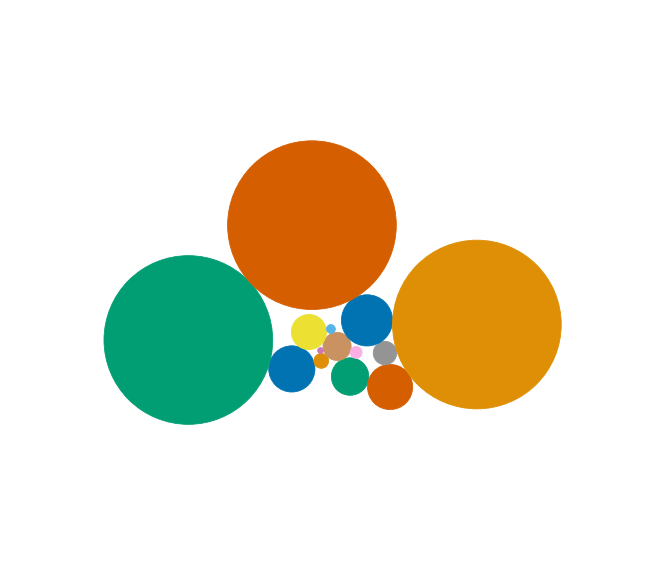

In [60]:
class C:
    def __init__(self, r, label, colors):
        self.N = len(r)
        self.x = np.ones((self.N, 3))
        self.x[:, 2] = r
        self.labels = label
        self.colors = colors
        maxstep = 2 * self.x[:, 2].max()
        length = np.ceil(np.sqrt(self.N))
        grid = np.arange(0, length * maxstep, maxstep)
        gx, gy = np.meshgrid(grid, grid)
        self.x[:, 0] = gx.flatten()[: self.N]
        self.x[:, 1] = gy.flatten()[: self.N]
        self.x[:, :2] = self.x[:, :2] - np.mean(self.x[:, :2], axis=0)

        self.step = self.x[:, 2].min()
        self.p = lambda x, y: np.sum((x ** 2 + y ** 2) ** 2)
        self.E = self.energy()
        self.iter = 1.0

    def minimize(self):
        while self.iter < 1000 * self.N:
            for i in range(self.N):
                rand = np.random.randn(2) * self.step / self.iter
                self.x[i, :2] += rand
                e = self.energy()
                if e < self.E and self.isvalid(i):
                    self.E = e
                    self.iter = 1.0
                else:
                    self.x[i, :2] -= rand
                    self.iter += 1.0

    def energy(self):
        return self.p(self.x[:, 0], self.x[:, 1])

    def distance(self, x1, x2):
        return np.sqrt((x1[0] - x2[0]) ** 2 + (x1[1] - x2[1]) ** 2) - x1[2] - x2[2]

    def isvalid(self, i):
        for j in range(self.N):
            if i != j:
                if self.distance(self.x[i, :], self.x[j, :]) < 0:
                    return False
        return True

    def plot(self, ax):
        for i in range(self.N):
            circ = plt.Circle(self.x[i, :2], self.x[i, 2], color=self.colors[i])

            #             ax.text(self.x[i,:2],self.x[i,2], 'sgfd', size=24, ha='center', va='center',color='k')
            ax.add_patch(circ)


#             label = ax.annotate(self.labels[i], xy=(self.x[i,:2]), fontsize=10, ha="center",color='k')


c = C(ratio_list2, [], colors2)

fig, ax = plt.subplots(subplot_kw=dict(aspect="equal"))
ax.axis("off")

c.minimize()

c.plot(ax)
ax.relim()
ax.autoscale_view()
plt.show()

<IPython.core.display.Javascript object>


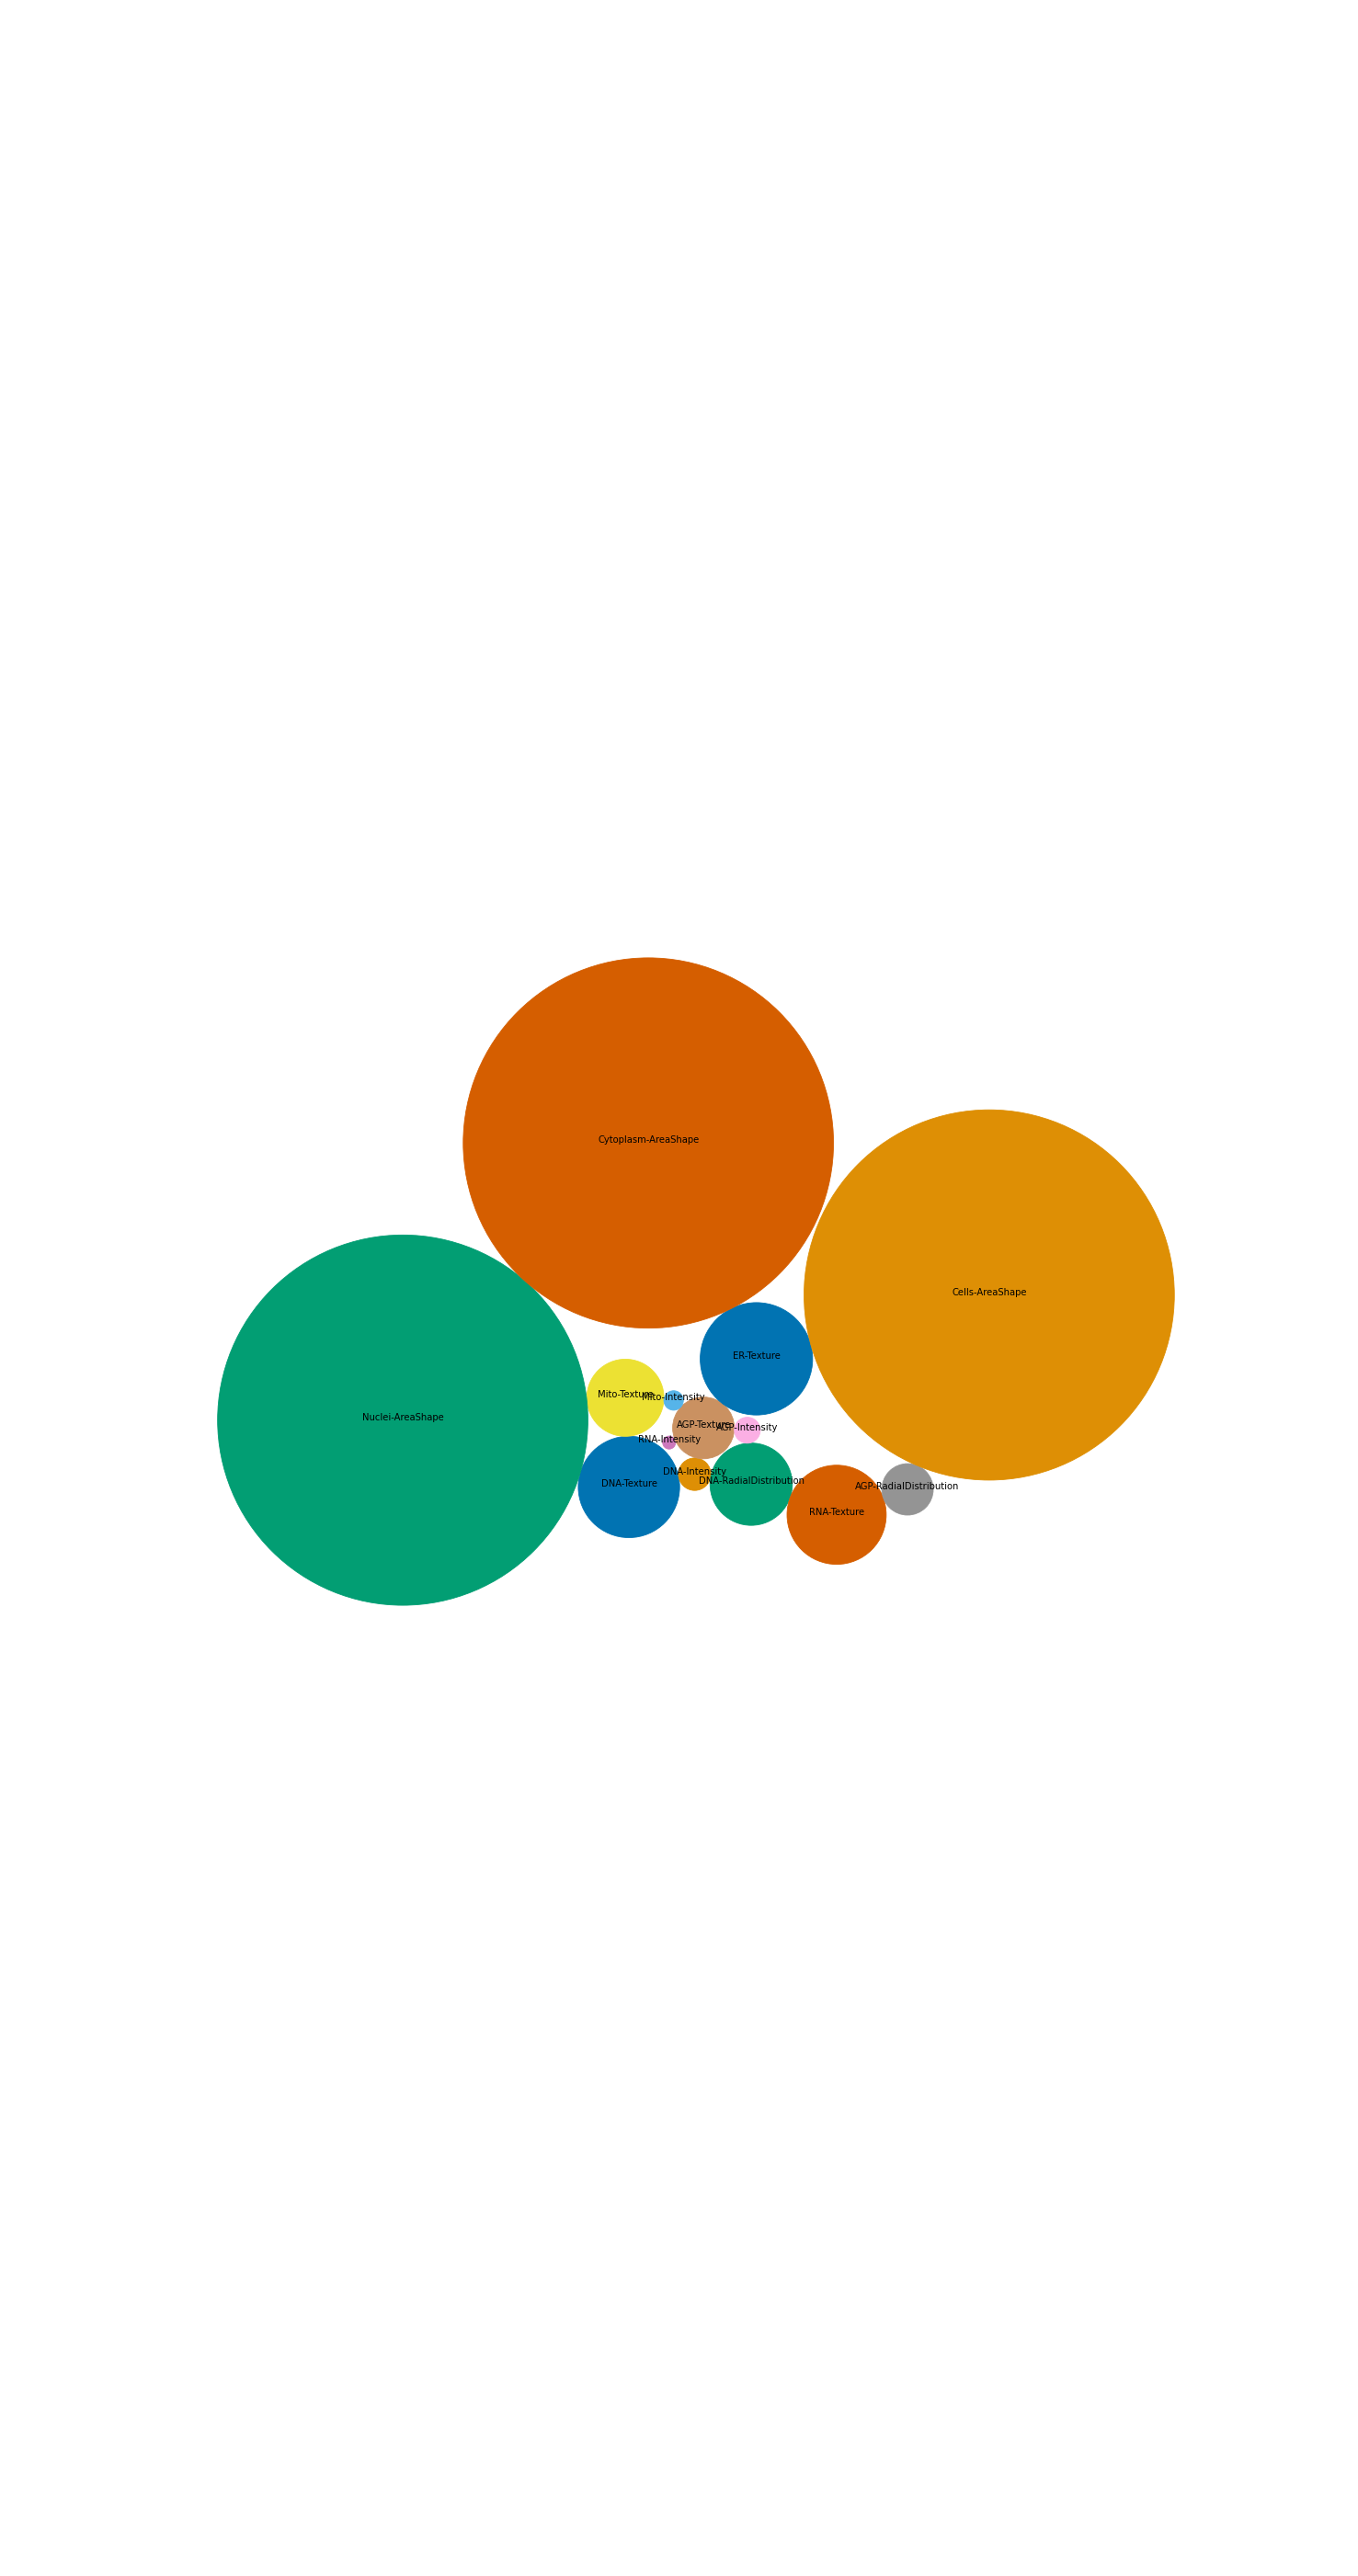

In [58]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

# create 10 circles with different radii
# r = np.random.randint(5,15, size=10)
# r =np.array([1,  5,  6, 1])
# label=['A','B','C','D']
# colors=['r','b','g','c']


label=['DNA','RNA','AGP','Mito','ER','Texture','Intensity','RadialDistribution',"AreaShape"]
r=[]
for l in label:
    r.append(len([s for s in topFeatures if (l in s)]))
    
    

r_t=[]
for l in label:
    r_t.append(len([s for s in cp_featuress if (l in s)]))    
    
ratio_list=[(r[i]/r_t[i])*100 for i in range(len(r))]    

colors=sns.color_palette("hls", len(label))

class C():
    def __init__(self,r,label,colors):
        self.N = len(r)
        self.x = np.ones((self.N,3))
        self.x[:,2] = r
        self.labels = label
        self.colors = colors
        maxstep = 2*self.x[:,2].max()
        length = np.ceil(np.sqrt(self.N))
        grid = np.arange(0,length*maxstep,maxstep)
        gx,gy = np.meshgrid(grid,grid)
        self.x[:,0] = gx.flatten()[:self.N]
        self.x[:,1] = gy.flatten()[:self.N]
        self.x[:,:2] = self.x[:,:2] - np.mean(self.x[:,:2], axis=0)

        self.step = self.x[:,2].min()
        self.p = lambda x,y: np.sum((x**2+y**2)**2)
        self.E = self.energy()
        self.iter = 1.

    def minimize(self):
        while self.iter < 1000*self.N:
            for i in range(self.N):
                rand = np.random.randn(2)*self.step/self.iter
                self.x[i,:2] += rand
                e = self.energy()
                if (e < self.E and self.isvalid(i)):
                    self.E = e
                    self.iter = 1.
                else:
                    self.x[i,:2] -= rand
                    self.iter += 1.

    def energy(self):
        return self.p(self.x[:,0], self.x[:,1])

    def distance(self,x1,x2):
        return np.sqrt((x1[0]-x2[0])**2+(x1[1]-x2[1])**2)-x1[2]-x2[2]

    def isvalid(self, i):
        for j in range(self.N):
            if i!=j: 
                if self.distance(self.x[i,:], self.x[j,:]) < 0:
                    return False
        return True

    def plot(self, ax):
        for i in range(self.N):
            circ = plt.Circle(self.x[i,:2],self.x[i,2],color=self.colors[i])
            
#             ax.text(self.x[i,:2],self.x[i,2], 'sgfd', size=24, ha='center', va='center',color='k')
            ax.add_patch(circ)
            label = ax.annotate(self.labels[i], xy=(self.x[i,:2]), fontsize=10, ha="center",color='k')
            

# c = C(r,label,colors)

# c = C(r2,label2,colors2)
c = C(ratio_list2,label2,colors2)

fig, ax = plt.subplots(subplot_kw=dict(aspect="equal"))
ax.axis("off")

c.minimize()

c.plot(ax)
ax.relim()
ax.autoscale_view()
plt.show()

## Feature categorical median prediction score 
- Figure 2d

In [4]:
filename = results_dir + "/SingleGenePred_cpCategoryMap/cat_scores_maps.xlsx"
saved_scores = pd.read_excel(filename, sheet_name=None)
saved_scores.keys()

dict_keys(['LUAD-9-lasso-ht', 'LINCS-25-lasso-ht', 'LINCS-25-MLP-ht', 'LUAD-9-MLP-ht'])

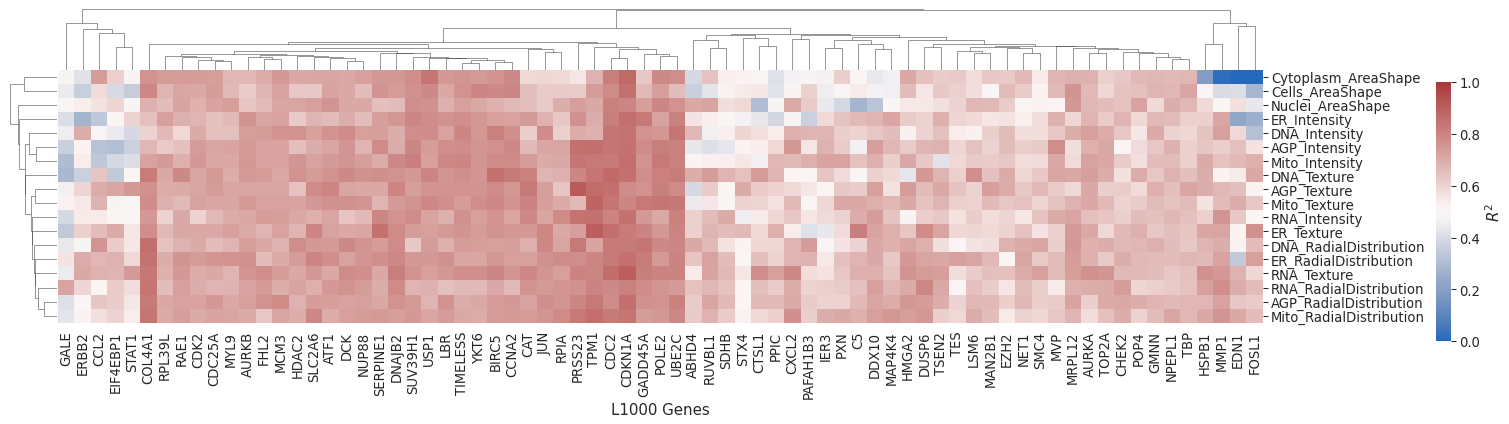

In [563]:
%matplotlib inline
which_ds_model='LUAD-9-lasso-ht'
dfcats=saved_scores[which_ds_model].rename(columns={'Unnamed: 0':'L1000 Genes'}).set_index('L1000 Genes')
dfcats=dfcats[dfcats.columns[~dfcats.isna().any()].tolist()]
topGenes_df2=dfcats[dfcats.max(axis=1)>0.7]

clustergrid=sns.clustermap(topGenes_df2.T,xticklabels=1,yticklabels=1,figsize=(20, 6),cmap="vlag",\
vmin=0, vmax=1,cbar_kws={'label': '$R^2$'},cbar_pos=(1, .2, .01, .6),dendrogram_ratio=(0.04,0.2))

# clustergrid.fig.suptitle('LUAD');
clustergrid.savefig(results_dir+'/SingleGenePred_cpCategoryMap/CatMap-'+which_ds_model+'.png', format='png',dpi=300)

In [77]:
dfcats.loc["STX4", :]


DNA_Texture                0.641127
DNA_Intensity              0.596006
DNA_RadialDistribution     0.518605
RNA_Texture                0.555905
RNA_Intensity              0.452827
RNA_RadialDistribution     0.503758
AGP_Texture                0.702942
AGP_Intensity              0.516014
AGP_RadialDistribution     0.501605
Mito_Texture               0.603559
Mito_Intensity             0.554152
Mito_RadialDistribution    0.520225
ER_Texture                 0.664619
ER_Intensity               0.465823
ER_RadialDistribution      0.484707
Nuclei_AreaShape           0.588656
Cytoplasm_AreaShape        0.516406
Cells_AreaShape            0.542763
Name: STX4, dtype: float64

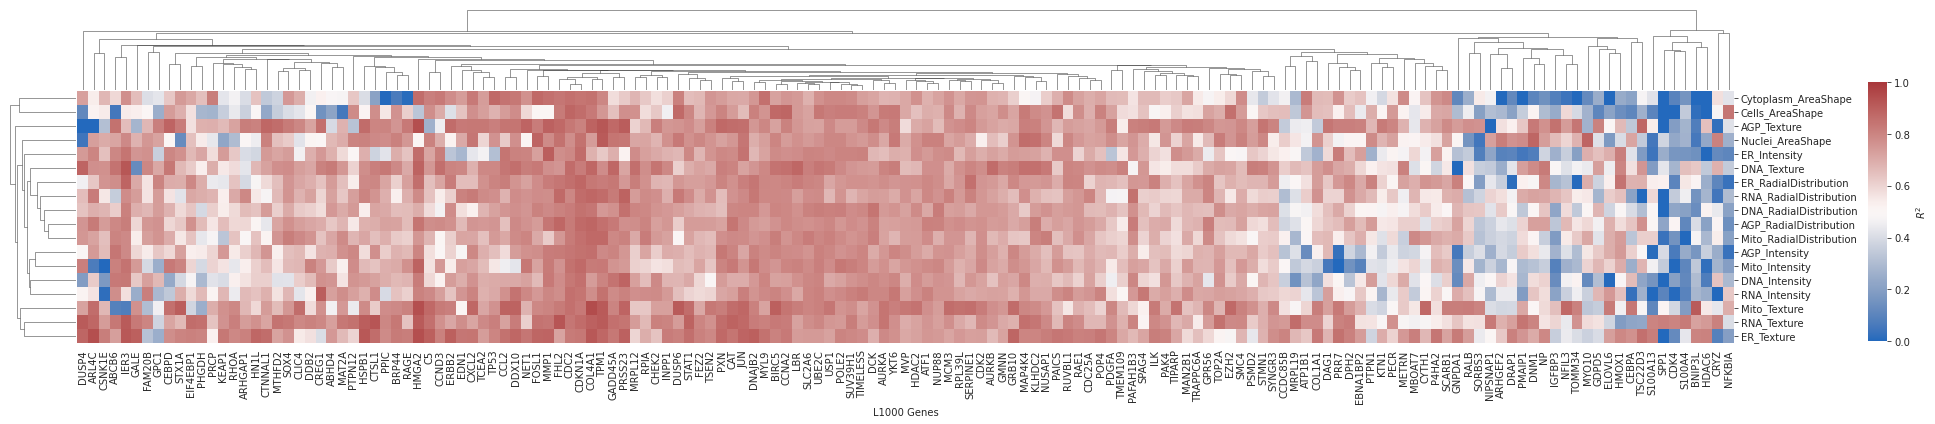

In [5]:
%matplotlib inline
which_ds_model='LUAD-9-MLP-ht'
dfcats=saved_scores[which_ds_model].rename(columns={'Unnamed: 0':'L1000 Genes'}).set_index('L1000 Genes')
dfcats=dfcats[dfcats.columns[~dfcats.isna().any()].tolist()]
dfcats['max']=dfcats.max(axis=1)
topGenes_df2=dfcats[dfcats.max(axis=1)>0.8]

# topGenes_df2=dfcats.sort_values(by='max',ascending=False)[0:150]  #figsize=(26, 6)

# topGenes_df2=dfcats.sort_values(by='max',ascending=False)[0:100] ->figsize=(22, 6)

topGenes_df2=topGenes_df2.drop(columns=['max'])

clustergrid=sns.clustermap(topGenes_df2.T,xticklabels=1,yticklabels=1,figsize=(26, 6),cmap="vlag",\
vmin=0, vmax=1,cbar_kws={'label': '$R^2$'},cbar_pos=(1, .2, .01, .6),dendrogram_ratio=(0.04,0.25))

# clustergrid.fig.suptitle('LUAD');
# clustergrid.savefig(results_dir+'/SingleGenePred_cpCategoryMap/CatMap-'+which_ds_model+'.png', format='png',dpi=400)

In [22]:
set(topGenes_df2.index) & set(l2check)


{'CDK4', 'MYO10', 'S100A13', 'S100A4', 'SPP1', 'TSC22D3'}

In [6]:
topGenes_df2.shape

(153, 18)

In [14]:
# l2check=['MYO10','PRKAG2','CISD1','SPP1', 'CDK4', 'S100A4', 'S100A13', 'TSC22D3']
l2check = ["MYO10", "SPP1", "CDK4", "S100A4", "S100A13", "TSC22D3"]


In [26]:
# dfcats_2=dfcats.copy()
# dfcats_2[dfcats_2<0.2]=0
# dfcats_2['median']=dfcats_2.median(axis=1)
# dfcats_2['q8']=dfcats_2.quantile(.7,axis=1)

# dfcats_2[dfcats_2['q8']==0].sort_values(by='max',ascending=False)[0:10]

In [25]:
# dfcats_2.loc[['ETFB','PRKAG2','CISD1']].T
# dfcats_2.loc[['TSC22D3','DNAJB1','LIPA','MAP3K4']].T

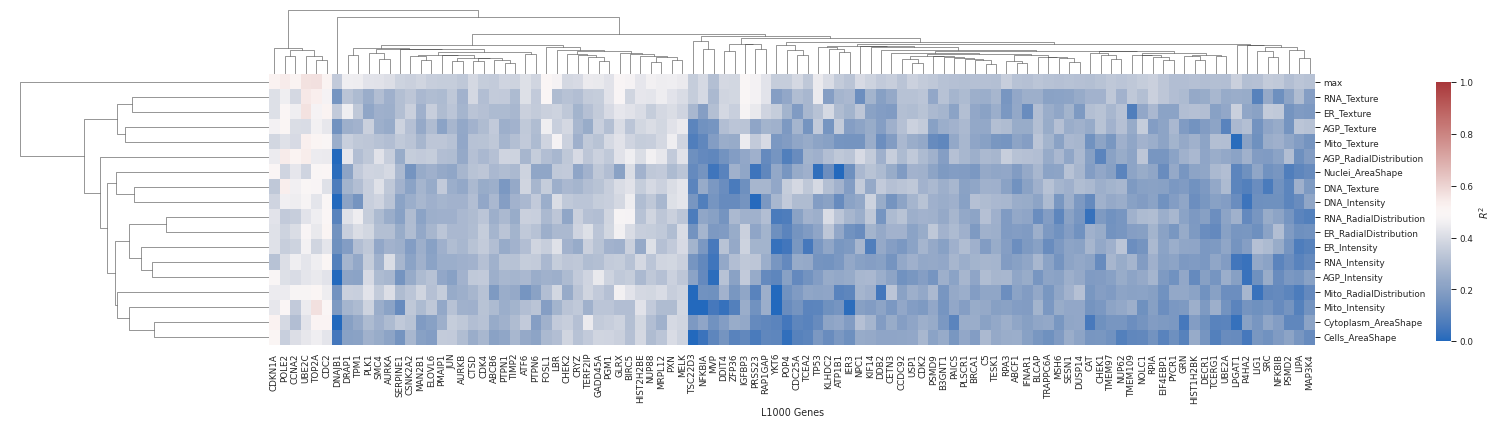

In [1169]:
%matplotlib inline
which_ds_model='LINCS-25-lasso-ht'
dfcats=saved_scores[which_ds_model].rename(columns={'Unnamed: 0':'L1000 Genes'}).set_index('L1000 Genes')
dfcats=dfcats[dfcats.columns[~dfcats.isna().any()].tolist()]
# topGenes_df2=dfcats[dfcats.max(axis=1)>0.4]
dfcats['max']=dfcats.max(axis=1)
topGenes_df2=dfcats.sort_values(by='max',ascending=False)[0:100]

clustergrid=sns.clustermap(topGenes_df2.T,xticklabels=1,yticklabels=1,figsize=(20, 6),cmap="vlag",\
                           vmin=0, vmax=1,cbar_kws={'label': '$R^2$'},cbar_pos=(1, .2, .01, .6))
# clustergrid.fig.suptitle('LUAD');
clustergrid.savefig(results_dir+'/SingleGenePred_cpCategoryMap/CatMap-'+which_ds_model+'.png', format='png',dpi=100)

In [84]:
dfcats

,DNA_Texture,DNA_Intensity,RNA_Texture,RNA_Intensity,RNA_RadialDistribution,AGP_Texture,AGP_Intensity,AGP_RadialDistribution,Mito_Texture,Mito_Intensity,Mito_RadialDistribution,ER_Texture,ER_Intensity,ER_RadialDistribution,Nuclei_AreaShape,Cytoplasm_AreaShape,Cells_AreaShape
L1000 Genes,,,,,,,,,,,,,,,,,
PSME1,0.198644,0.114170,0.263495,0.103871,0.091311,0.173546,0.013167,0.218375,0.157273,0.107764,0.130951,0.268080,0.018866,0.084901,0.074853,0.004780,0.058287
ATF1,-0.041889,-0.015528,-0.018930,-0.050327,-0.037024,-0.021075,-0.017903,-0.018240,-0.024953,-0.020574,-0.044069,-0.003375,-0.011892,-0.076104,-0.018911,-0.105728,-0.019628
RHEB,0.007836,-0.000927,-0.050240,-0.076271,-0.093574,-0.060072,-0.085477,-0.021397,0.002194,-0.041626,0.026241,-0.072862,-0.018045,-0.031927,-0.035166,-0.048785,-0.040388
FOXO3,0.034839,0.008234,0.132048,0.102796,0.002918,0.104290,0.043792,-0.014698,-0.034965,-0.047492,-0.017042,0.131368,0.130041,0.066229,0.113105,0.128763,0.022583
RHOA,0.052866,-0.001764,0.090261,-0.003245,0.041445,0.042332,0.039936,0.018079,-0.011993,-0.014796,-0.001911,0.027529,-0.000881,0.060517,0.026867,-0.009882,0.001283
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ATP11B,0.050580,0.025909,0.044148,0.077803,0.063940,0.056028,0.038916,0.046106,0.042578,0.044740,0.035354,0.041566,0.038908,0.068602,0.021458,0.034322,0.004981
CD320,0.130195,0.050176,0.079361,0.058391,0.071766,0.090185,0.049968,0.070713,0.109930,0.056504,0.066496,0.073655,0.055733,0.100834,0.049456,0.070379,0.073514
MLLT11,-0.056618,-0.047253,-0.021668,-0.077626,-0.056272,-0.047253,-0.047253,-0.054070,0.003178,-0.050546,-0.082247,-0.056618,-0.032774,-0.092375,-0.016948,-0.133620,-0.100847


## Modality Integration

In [585]:
# filename=results_dir+'/MoAprediction/pred_moa.xlsx'
filename = results_dir + "/MoAprediction/pred_moa_CDRP.xlsx"
saved_scores_cdrpbio = pd.read_excel(filename, sheet_name=None)
saved_scores_cdrpbio.keys()

dict_keys(['fC-LINCS-nvs-filt-preds-lr-ht', 'fC-LINCS-nvs-filt-preds-mlp-ht', 'fC-LINCS-nvs-filt-preds-lr-ht2', 'fCCA-LINCS-nvs-filt-preds-lr-ht2', 'fCCA-LINCS-nvs-filt-preds-mlp-ht2', 'fC-LINCS-nvs-filt-preds-mlp-ht2', 'fuseSNF-LINCS-nvs-filt-2', 'fC-CDRP-bio-nvs-filt-preds-lr-ht', 'fCCA-CDRP-bio-nvs-filt-preds-lr-ht', 'fC-CDRP-bio-nvs-filt-preds-mlp-ht', 'fCCA-CDRP-bio-nvs-filt-preds-mlp-ht', 'fC-CDRP-bio-nvs-filt-preds-mlp-ht-2', 'fC-CDRP-bio-nvs-filt-preds-lr-ht-2', 'fC-CDRP-bio-nvs-filt-preds-lr-ht-3', 'fC-CDRP-bio-nvs-filt-preds-mlp-ht-3', 'fC-CDRP-bio-nvs-filt-preds-lr-ht-4', 'fC-CDRP-bio-nvs-filt-preds-mlp-ht-4', 'fC-CDRP-bio-nvs-filt-preds-lr-ht-5', 'fC-CDRP-bio-nvs-filt-preds-mlp-ht-5'])

In [594]:
filename = results_dir + "/MoAprediction/pred_moa_LINCS.xlsx"
saved_scores_lincs = pd.read_excel(filename, sheet_name=None)
saved_scores_lincs.keys()

dict_keys(['fC-LINCS-nvs-filt-preds-lr-ht-2', 'fC-LINCS-nvs-filt-preds-mlp-ht-2', 'fC-LINCS-nvs-filt-preds-lr-ht-3', 'fC-LINCS-nvs-filt-preds-mlp-ht-3'])

In [50]:
# from sklearn.metrics import f1_score
# res_df=pd.DataFrame(columns=['Modality','Model'])
# DS='LINCS'
# scores_mlp=saved_scores['fC-'+DS+'-nvs-filt-preds-lr-ht']
# mofa_scores_2add=saved_scores['mofa-100fac'+DS+'-nvs-filt-preds-lr-ht']

In [51]:
# mofa_scores_2add

In [595]:
from sklearn.metrics import f1_score

res_df_lincs = pd.DataFrame(columns=["Modality", "Model"])
DS = "LINCS"
scores_mlp = saved_scores_lincs["fC-" + DS + "-nvs-filt-preds-mlp-ht-3"]
# mofa_scores_2add=saved_scores['mofa-100fac'+DS+'-nvs-filt-preds-mlp-ht-2']
# scores_mlp['mofa']=mofa_scores_2add['mofa']


for dd in ["CP", "GE", "Early Fusion", "Late Fusion", "RGCCA_EarlyFusion"]:
    scor_vals = scores_mlp[dd].apply(lambda x: int(eval(x)[0]) if type(x) == str else x)
    f1 = f1_score(scor_vals, scores_mlp.Metadata_moa_num.values, average="macro")
    temp_df = pd.DataFrame(
        data={"Modality": [dd], "Model": ["MLP"], "F1-score": [f1 * 100]}
    )
    res_df_lincs = res_df_lincs.append(temp_df)


scores_mlp = saved_scores_lincs["fC-" + DS + "-nvs-filt-preds-lr-ht-3"]
# mofa_scores_2add=saved_scores['mofa-100fac'+DS+'-nvs-filt-preds-lr-ht-2']
# scores_mlp['mofa']=mofa_scores_2add['mofa']

# for dd in ['CP', 'GE', 'Early Fusion', 'Late Fusion','RGCCA_CP','RGCCA_GE','RGCCA_EarlyFusion']:
for dd in ["CP", "GE", "Early Fusion", "Late Fusion", "RGCCA_EarlyFusion"]:
    scor_vals = scores_mlp[dd].apply(lambda x: int(eval(x)[0]) if type(x) == str else x)
    f1 = f1_score(scores_mlp.Metadata_moa_num.values, scor_vals, average="macro")
    temp_df = pd.DataFrame(
        data={"Modality": [dd], "Model": ["Logistic R"], "F1-score": [f1 * 100]}
    )
    res_df_lincs = res_df_lincs.append(temp_df)


#########################################################
res_df_cdrpbio = pd.DataFrame(columns=["Modality", "Model"])
DS = "CDRP-bio"
scores_mlp = saved_scores_cdrpbio["fC-" + DS + "-nvs-filt-preds-mlp-ht-5"]
# mofa_scores_2add=saved_scores['mofa-100fac'+DS+'-nvs-filt-preds-mlp-ht-2']
# scores_mlp['mofa']=mofa_scores_2add['mofa']


for dd in ["CP", "GE", "Early Fusion", "Late Fusion", "RGCCA_EarlyFusion"]:
    scor_vals = scores_mlp[dd].apply(lambda x: int(eval(x)[0]) if type(x) == str else x)
    f1 = f1_score(scor_vals, scores_mlp.Metadata_moa_num.values, average="macro")
    temp_df = pd.DataFrame(
        data={"Modality": [dd], "Model": ["MLP"], "F1-score": [f1 * 100]}
    )
    res_df_cdrpbio = res_df_cdrpbio.append(temp_df)


scores_mlp = saved_scores_cdrpbio["fC-" + DS + "-nvs-filt-preds-lr-ht-5"]
# mofa_scores_2add=saved_scores['mofa-100fac'+DS+'-nvs-filt-preds-lr-ht-2']
# scores_mlp['mofa']=mofa_scores_2add['mofa']

# for dd in ['CP', 'GE', 'Early Fusion', 'Late Fusion','RGCCA_CP','RGCCA_GE','RGCCA_EarlyFusion']:
for dd in ["CP", "GE", "Early Fusion", "Late Fusion", "RGCCA_EarlyFusion"]:
    scor_vals = scores_mlp[dd].apply(lambda x: int(eval(x)[0]) if type(x) == str else x)
    f1 = f1_score(scores_mlp.Metadata_moa_num.values, scor_vals, average="macro")
    temp_df = pd.DataFrame(
        data={"Modality": [dd], "Model": ["Logistic R"], "F1-score": [f1 * 100]}
    )
    res_df_cdrpbio = res_df_cdrpbio.append(temp_df)


/tmp/ipykernel_64355/2771550366.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  res_df_lincs=res_df_lincs.append(temp_df)
/tmp/ipykernel_64355/2771550366.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  res_df_lincs=res_df_lincs.append(temp_df)
/tmp/ipykernel_64355/2771550366.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  res_df_lincs=res_df_lincs.append(temp_df)
/tmp/ipykernel_64355/2771550366.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  res_df_lincs=res_df_lincs.append(temp_df)
/tmp/ipykernel_64355/2771550366.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future 

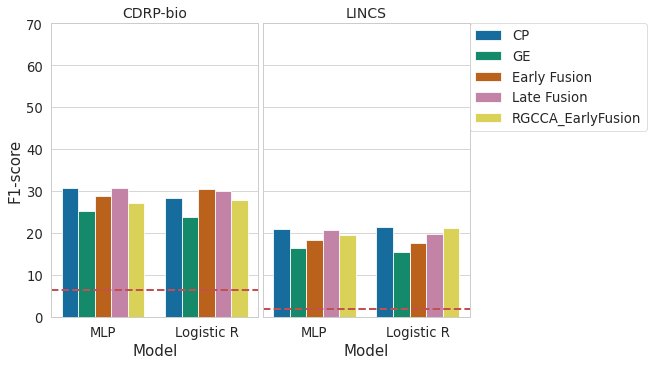

In [596]:
import matplotlib.style as style

style.use("seaborn-colorblind")
sns.set_context(
    "paper",
    font_scale=1.5,
    rc={"font.size": 4, "axes.titlesize": 14, "axes.labelsize": 15},
)
res_df1 = res_df_lincs[res_df_lincs["Modality"] != "Early Fusion"]
res_df2 = res_df_lincs[res_df_lincs["Modality"] != "Late Fusion"]

sns.set_style("whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(9, 5), sharey=True)
sns.barplot(
    x="Model", y="F1-score", hue="Modality", data=res_df_cdrpbio, ax=axes[0]
)  # ,**kwargs)
# plt.legend(loc='top', borderaxespad=0)
# plt.legend(bbox_to_anchor=(0.27, 1), loc='upper left', borderaxespad=0)
axes[0].legend([], [], frameon=False)
plt.tight_layout()
# axes[0].set_ylim(0,60)
axes[0].set_title("CDRP-bio")
n_classes = 16
axes[0].axhline(y=(100 / n_classes), linestyle="--", color="r", linewidth=2)

###################
sns.barplot(
    x="Model", y="F1-score", hue="Modality", data=res_df_lincs, ax=axes[1]
)  # ,**kwargs)
# plt.legend(loc='top', borderaxespad=0)
plt.legend(bbox_to_anchor=(1, 1), loc="upper left", borderaxespad=0)
plt.tight_layout()
axes[1].set_ylim(0, 70)
axes[1].set_title("LINCS")
axes[1].set(ylabel=None)
n_classes = 57
axes[1].axhline(y=(100 / n_classes), linestyle="--", color="r", linewidth=2)

plt.tight_layout()
# for a in ax.patches:
#     a.set_width(0.15)
# plt.savefig('moa_class_bar.png')

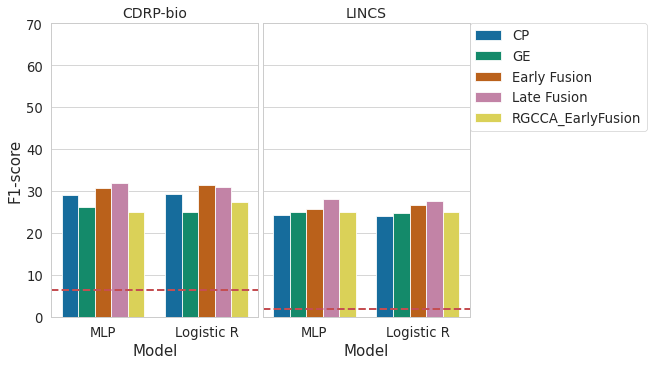

In [581]:
import matplotlib.style as style

style.use("seaborn-colorblind")
sns.set_context(
    "paper",
    font_scale=1.5,
    rc={"font.size": 4, "axes.titlesize": 14, "axes.labelsize": 15},
)
res_df1 = res_df_lincs[res_df_lincs["Modality"] != "Early Fusion"]
res_df2 = res_df_lincs[res_df_lincs["Modality"] != "Late Fusion"]

sns.set_style("whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(9, 5), sharey=True)
sns.barplot(
    x="Model", y="F1-score", hue="Modality", data=res_df_cdrpbio, ax=axes[0]
)  # ,**kwargs)
# plt.legend(loc='top', borderaxespad=0)
# plt.legend(bbox_to_anchor=(0.27, 1), loc='upper left', borderaxespad=0)
axes[0].legend([], [], frameon=False)
plt.tight_layout()
# axes[0].set_ylim(0,60)
axes[0].set_title("CDRP-bio")
n_classes = 16
axes[0].axhline(y=(100 / n_classes), linestyle="--", color="r", linewidth=2)

###################
sns.barplot(
    x="Model", y="F1-score", hue="Modality", data=res_df_lincs, ax=axes[1]
)  # ,**kwargs)
# plt.legend(loc='top', borderaxespad=0)
plt.legend(bbox_to_anchor=(1, 1), loc="upper left", borderaxespad=0)
plt.tight_layout()
axes[1].set_ylim(0, 70)
axes[1].set_title("LINCS")
axes[1].set(ylabel=None)
n_classes = 57
axes[1].axhline(y=(100 / n_classes), linestyle="--", color="r", linewidth=2)

plt.tight_layout()
# for a in ax.patches:
#     a.set_width(0.15)
# plt.savefig('moa_class_bar.png')

<IPython.core.display.Javascript object>


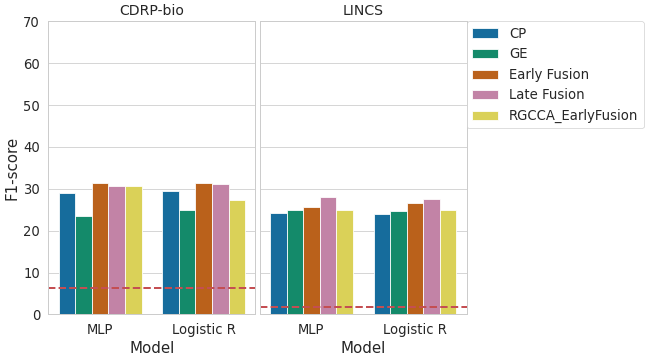

In [547]:
import matplotlib.style as style

style.use("seaborn-colorblind")
sns.set_context(
    "paper",
    font_scale=1.5,
    rc={"font.size": 4, "axes.titlesize": 14, "axes.labelsize": 15},
)
res_df1 = res_df_lincs[res_df_lincs["Modality"] != "Early Fusion"]
res_df2 = res_df_lincs[res_df_lincs["Modality"] != "Late Fusion"]

sns.set_style("whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(9, 5), sharey=True)
sns.barplot(
    x="Model", y="F1-score", hue="Modality", data=res_df_cdrpbio, ax=axes[0]
)  # ,**kwargs)
# plt.legend(loc='top', borderaxespad=0)
# plt.legend(bbox_to_anchor=(0.27, 1), loc='upper left', borderaxespad=0)
axes[0].legend([], [], frameon=False)
plt.tight_layout()
# axes[0].set_ylim(0,60)
axes[0].set_title("CDRP-bio")
n_classes = 16
axes[0].axhline(y=(100 / n_classes), linestyle="--", color="r", linewidth=2)

###################
sns.barplot(
    x="Model", y="F1-score", hue="Modality", data=res_df_lincs, ax=axes[1]
)  # ,**kwargs)
# plt.legend(loc='top', borderaxespad=0)
plt.legend(bbox_to_anchor=(1, 1), loc="upper left", borderaxespad=0)
plt.tight_layout()
axes[1].set_ylim(0, 70)
axes[1].set_title("LINCS")
axes[1].set(ylabel=None)
n_classes = 57
axes[1].axhline(y=(100 / n_classes), linestyle="--", color="r", linewidth=2)

plt.tight_layout()
# for a in ax.patches:
#     a.set_width(0.15)
# plt.savefig('moa_class_bar.png')

<IPython.core.display.Javascript object>


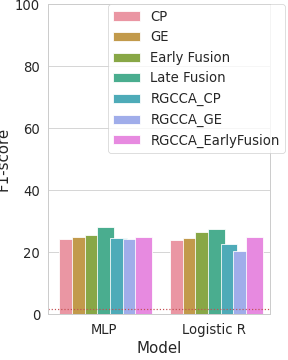

In [425]:
import matplotlib.style as style

style.use("seaborn-colorblind")
sns.set_context(
    "paper",
    font_scale=1.5,
    rc={"font.size": 4, "axes.titlesize": 14, "axes.labelsize": 15},
)
res_df1 = res_df[res_df["Modality"] != "Early Fusion"]
res_df2 = res_df[res_df["Modality"] != "Late Fusion"]

sns.set_style("whitegrid")
plt.figure(figsize=(4, 5))
ax = sns.barplot(x="Model", y="F1-score", hue="Modality", data=res_df)  # ,**kwargs)
# ax = sns.barplot(x="Model", y="F1-score", hue="Modality", data=res_df2)
# ax.legend(ncol = 1, loc = 'upper center')
# plt.legend(loc='top', borderaxespad=0)
plt.legend(bbox_to_anchor=(0.27, 1), loc="upper left", borderaxespad=0)
plt.tight_layout()
ax.set_ylim(0, 100)
ax.set_title(DS)
n_classes = 57
ax.axhline(y=(100 / n_classes), linestyle=":", color="r")

for a in ax.patches:
    a.set_width(0.15)
# plt.savefig('moa_class_bar.eps')

<IPython.core.display.Javascript object>


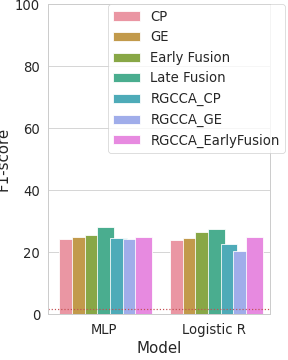

In [426]:
import matplotlib.style as style

style.use("seaborn-colorblind")
sns.set_context(
    "paper",
    font_scale=1.5,
    rc={"font.size": 4, "axes.titlesize": 14, "axes.labelsize": 15},
)
res_df1 = res_df[res_df["Modality"] != "Early Fusion"]
res_df2 = res_df[res_df["Modality"] != "Late Fusion"]

sns.set_style("whitegrid")
plt.figure(figsize=(4, 5))
ax = sns.barplot(x="Model", y="F1-score", hue="Modality", data=res_df)  # ,**kwargs)
# ax = sns.barplot(x="Model", y="F1-score", hue="Modality", data=res_df2)
# ax.legend(ncol = 1, loc = 'upper center')
# plt.legend(loc='top', borderaxespad=0)
plt.legend(bbox_to_anchor=(0.27, 1), loc="upper left", borderaxespad=0)
plt.tight_layout()
ax.set_ylim(0, 100)
ax.set_title(DS)
n_classes = 57
ax.axhline(y=(100 / n_classes), linestyle=":", color="r")

for a in ax.patches:
    a.set_width(0.15)
# plt.savefig('moa_class_bar.eps')

## Modality Integration - k-fold
- Figure 4b

In [647]:
# filename=results_dir+'/MoAprediction/pred_moa.xlsx'
filename = results_dir + "/MoAprediction/pred_moa_CDRP.xlsx"
saved_scores_cdrpbio = pd.read_excel(filename, sheet_name=None)
saved_scores_cdrpbio.keys()

filename = results_dir + "/MoAprediction/pred_moa_LINCS.xlsx"
saved_scores_lincs = pd.read_excel(filename, sheet_name=None)
saved_scores_lincs.keys()

dict_keys(['fC-LINCS-nvs-filt-preds-lr-ht-2', 'fC-LINCS-nvs-filt-preds-mlp-ht-2', 'fC-LINCS-nvs-filt-preds-lr-ht-3', 'fC-LINCS-nvs-filt-preds-mlp-ht-3', 'fC-LINCS-nvs-filt-preds-mlp-ht-sgkf', 'fC-LINCS-nvs-filt-preds-lr-ht-sgkf', 'fC-LINCS-nvs-filt-preds-mlp-ht-sgkf-1', 'fC-LINCS-nvs-filt-preds-lr-ht-sgkf-1', 'fC-LINCS-nvs-filt-preds-mlp-ht-sgkf-10f', 'fC-LINCS-nvs-filt-preds-lr-ht-sgkf-10f'])

In [726]:
from sklearn.metrics import f1_score

res_df_lincs = pd.DataFrame(columns=["Modality", "Model"])
DS = "LINCS"
scores_mlp = saved_scores_lincs["fC-" + DS + "-nvs-filt-preds-mlp-ht-sgkf-1"]
# mofa_scores_2add=saved_scores['mofa-100fac'+DS+'-nvs-filt-preds-mlp-ht-2']
# scores_mlp['mofa']=mofa_scores_2add['mofa']

folds = scores_mlp["Fold"].unique().tolist()
for f in folds:
    scores_mlp_f = scores_mlp[scores_mlp["Fold"] == f]
    for dd in ["CP", "GE", "Early Fusion", "Late Fusion", "RGCCA_EarlyFusion"]:
        scor_vals = scores_mlp_f[dd].apply(
            lambda x: int(eval(x)[0]) if type(x) == str else x
        )
        f1 = f1_score(scor_vals, scores_mlp_f.Metadata_moa_num.values, average="macro")
        temp_df = pd.DataFrame(
            data={"Modality": [dd], "Model": ["MLP"], "F1-score": [f1]}
        )
        res_df_lincs = res_df_lincs.append(temp_df)


scores_mlp = saved_scores_lincs["fC-" + DS + "-nvs-filt-preds-lr-ht-sgkf-1"]
# mofa_scores_2add=saved_scores['mofa-100fac'+DS+'-nvs-filt-preds-lr-ht-2']
# scores_mlp['mofa']=mofa_scores_2add['mofa']
folds = scores_mlp["Fold"].unique().tolist()
for f in folds:
    scores_mlp_f = scores_mlp[scores_mlp["Fold"] == f]
    # for dd in ['CP', 'GE', 'Early Fusion', 'Late Fusion','RGCCA_CP','RGCCA_GE','RGCCA_EarlyFusion']:
    for dd in ["CP", "GE", "Early Fusion", "Late Fusion", "RGCCA_EarlyFusion"]:
        scor_vals = scores_mlp_f[dd].apply(
            lambda x: int(eval(x)[0]) if type(x) == str else x
        )
        f1 = f1_score(scores_mlp_f.Metadata_moa_num.values, scor_vals, average="macro")
        temp_df = pd.DataFrame(
            data={"Modality": [dd], "Model": ["Logistic R"], "F1-score": [f1]}
        )
        res_df_lincs = res_df_lincs.append(temp_df)


#########################################################
res_df_cdrpbio = pd.DataFrame(columns=["Modality", "Model"])
DS = "CDRP-bio"
scores_mlp = saved_scores_cdrpbio["fC-" + DS + "-nvs-filt-preds-mlp-ht-sgkf-1"]
# mofa_scores_2add=saved_scores['mofa-100fac'+DS+'-nvs-filt-preds-mlp-ht-2']
# scores_mlp['mofa']=mofa_scores_2add['mofa']

folds = scores_mlp["Fold"].unique().tolist()
for f in folds:
    scores_mlp_f = scores_mlp[scores_mlp["Fold"] == f]
    for dd in ["CP", "GE", "Early Fusion", "Late Fusion", "RGCCA_EarlyFusion"]:
        scor_vals = scores_mlp_f[dd].apply(
            lambda x: int(eval(x)[0]) if type(x) == str else x
        )

        f1 = f1_score(scor_vals, scores_mlp_f.Metadata_moa_num.values, average="macro")
        temp_df = pd.DataFrame(
            data={"Modality": [dd], "Model": ["MLP"], "F1-score": [f1]}
        )
        res_df_cdrpbio = res_df_cdrpbio.append(temp_df)


scores_mlp = saved_scores_cdrpbio["fC-" + DS + "-nvs-filt-preds-lr-ht-sgkf-1"]
# mofa_scores_2add=saved_scores['mofa-100fac'+DS+'-nvs-filt-preds-lr-ht-2']
# scores_mlp['mofa']=mofa_scores_2add['mofa']

folds = scores_mlp["Fold"].unique().tolist()
for f in folds:
    scores_mlp_f = scores_mlp[scores_mlp["Fold"] == f]
    # for dd in ['CP', 'GE', 'Early Fusion', 'Late Fusion','RGCCA_CP','RGCCA_GE','RGCCA_EarlyFusion']:
    for dd in ["CP", "GE", "Early Fusion", "Late Fusion", "RGCCA_EarlyFusion"]:
        scor_vals = scores_mlp_f[dd].apply(
            lambda x: int(eval(x)[0]) if type(x) == str else x
        )
        f1 = f1_score(scores_mlp_f.Metadata_moa_num.values, scor_vals, average="macro")
        temp_df = pd.DataFrame(
            data={"Modality": [dd], "Model": ["Logistic R"], "F1-score": [f1]}
        )
        res_df_cdrpbio = res_df_cdrpbio.append(temp_df)


/tmp/ipykernel_64355/998719761.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  res_df_lincs=res_df_lincs.append(temp_df)
/tmp/ipykernel_64355/998719761.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  res_df_lincs=res_df_lincs.append(temp_df)
/tmp/ipykernel_64355/998719761.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  res_df_lincs=res_df_lincs.append(temp_df)
/tmp/ipykernel_64355/998719761.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  res_df_lincs=res_df_lincs.append(temp_df)
/tmp/ipykernel_64355/998719761.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future versi

/tmp/ipykernel_64355/998719761.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  res_df_lincs=res_df_lincs.append(temp_df)
/tmp/ipykernel_64355/998719761.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  res_df_lincs=res_df_lincs.append(temp_df)
/tmp/ipykernel_64355/998719761.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  res_df_lincs=res_df_lincs.append(temp_df)
/tmp/ipykernel_64355/998719761.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  res_df_lincs=res_df_lincs.append(temp_df)
/tmp/ipykernel_64355/998719761.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future versi

/tmp/ipykernel_64355/998719761.py:62: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  res_df_cdrpbio=res_df_cdrpbio.append(temp_df)
/tmp/ipykernel_64355/998719761.py:62: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  res_df_cdrpbio=res_df_cdrpbio.append(temp_df)
/tmp/ipykernel_64355/998719761.py:62: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  res_df_cdrpbio=res_df_cdrpbio.append(temp_df)
/tmp/ipykernel_64355/998719761.py:62: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  res_df_cdrpbio=res_df_cdrpbio.append(temp_df)
/tmp/ipykernel_64355/998719761.py:62: FutureWarning: The frame.append method is deprecated and will be removed from pandas i

In [672]:
# res_df_cdrpbio

In [727]:
# * Statistical tests for differences in the features across groups
from scipy import stats

all_t = list()
all_p = list()
for m in ["Logistic R", "MLP"]:
    sub_df = res_df_cdrpbio[res_df_cdrpbio["Model"] == m]
    g1 = sub_df[sub_df["Modality"] == "CP"]["F1-score"].values
    for di in ["GE", "Early Fusion", "Late Fusion", "RGCCA_EarlyFusion"]:
        g2 = sub_df[sub_df["Modality"] == di]["F1-score"].values
        t, p = stats.ttest_ind(g1, g2)
        all_t.append(t)
        all_p.append(p)
all_p

[0.3031560127773929,
 0.4666851266556845,
 0.44818749664764623,
 0.9730169197185375,
 0.47409275076272006,
 0.14985592805684134,
 0.5032117553347092,
 0.22250340210040548]

In [728]:
# * Statistical tests for differences in the features across groups
from scipy import stats

all_t = list()
all_p = list()
for m in ["Logistic R", "MLP"]:
    sub_df = res_df_lincs[res_df_lincs["Model"] == m]
    g1 = sub_df[sub_df["Modality"] == "CP"]["F1-score"].values
    for di in ["GE", "Early Fusion", "Late Fusion", "RGCCA_EarlyFusion"]:
        g2 = sub_df[sub_df["Modality"] == di]["F1-score"].values
        t, p = stats.ttest_ind(g1, g2)
        all_t.append(t)
        all_p.append(p)
all_p

[0.21109404613219504,
 0.9293941306664724,
 0.9494551739740308,
 0.1797328733728185,
 0.28876025568582236,
 0.91006421470726,
 0.19382382634652767,
 0.3029644724212067]

<IPython.core.display.Javascript object>


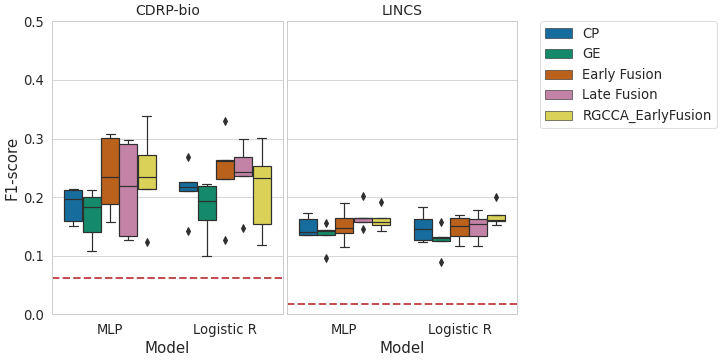

In [731]:
# res_df_cdrpbio
import matplotlib.style as style

style.use("seaborn-colorblind")
sns.set_context(
    "paper",
    font_scale=1.5,
    rc={"font.size": 4, "axes.titlesize": 14, "axes.labelsize": 15},
)
res_df1 = res_df_lincs[res_df_lincs["Modality"] != "Early Fusion"]
res_df2 = res_df_lincs[res_df_lincs["Modality"] != "Late Fusion"]

# sns.set_style("whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
# sns.barplot(x="Model", y="F1-score", hue="Modality", data=res_df_cdrpbio,ax=axes[0])#,**kwargs)
sns.boxplot(
    x="Model", y="F1-score", hue="Modality", data=res_df_cdrpbio, ax=axes[0]
)  # ,**kwargs)
# plt.legend(loc='top', borderaxespad=0)
# plt.legend(bbox_to_anchor=(0.27, 1), loc='upper left', borderaxespad=0)
axes[0].legend([], [], frameon=False)
plt.tight_layout()
axes[0].set_ylim(0, 50)
axes[0].set_title("CDRP-bio")
n_classes = 16
axes[0].axhline(y=(1 / n_classes), linestyle="--", color="r", linewidth=2)

###################
# sns.barplot(x="Model", y="F1-score", hue="Modality", data=res_df_lincs,ax=axes[1])#,**kwargs)
sns.boxplot(
    x="Model", y="F1-score", hue="Modality", data=res_df_lincs, ax=axes[1]
)  # ,**kwargs)
# plt.legend(loc='top', borderaxespad=0)
plt.legend(bbox_to_anchor=(1.1, 1), loc="upper left", borderaxespad=0)
plt.tight_layout()
axes[1].set_ylim(0, 0.5)
axes[1].set_title("LINCS")
axes[1].set(ylabel=None)
n_classes = 57
axes[1].axhline(y=(1 / n_classes), linestyle="--", color="r", linewidth=2)

plt.tight_layout()
# for a in ax.patches:
#     a.set_width(0.15)
# plt.savefig('moa_class_bar.png')

## Supplementary E - Top 50 CP using MLP
- Supplementary Figure 3

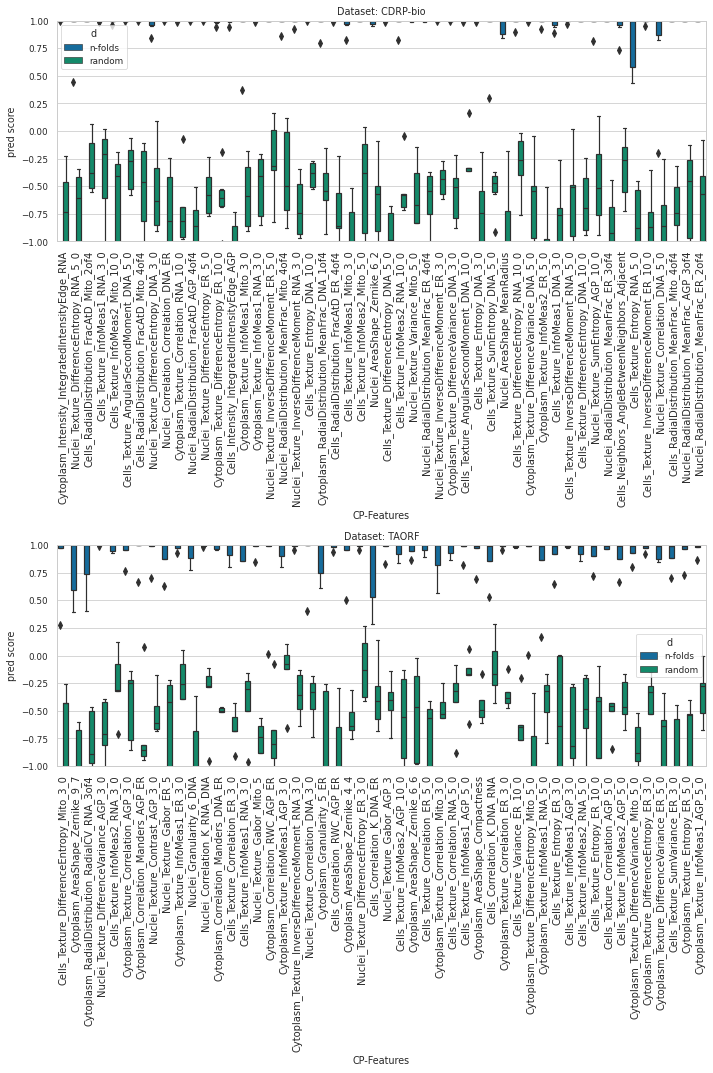

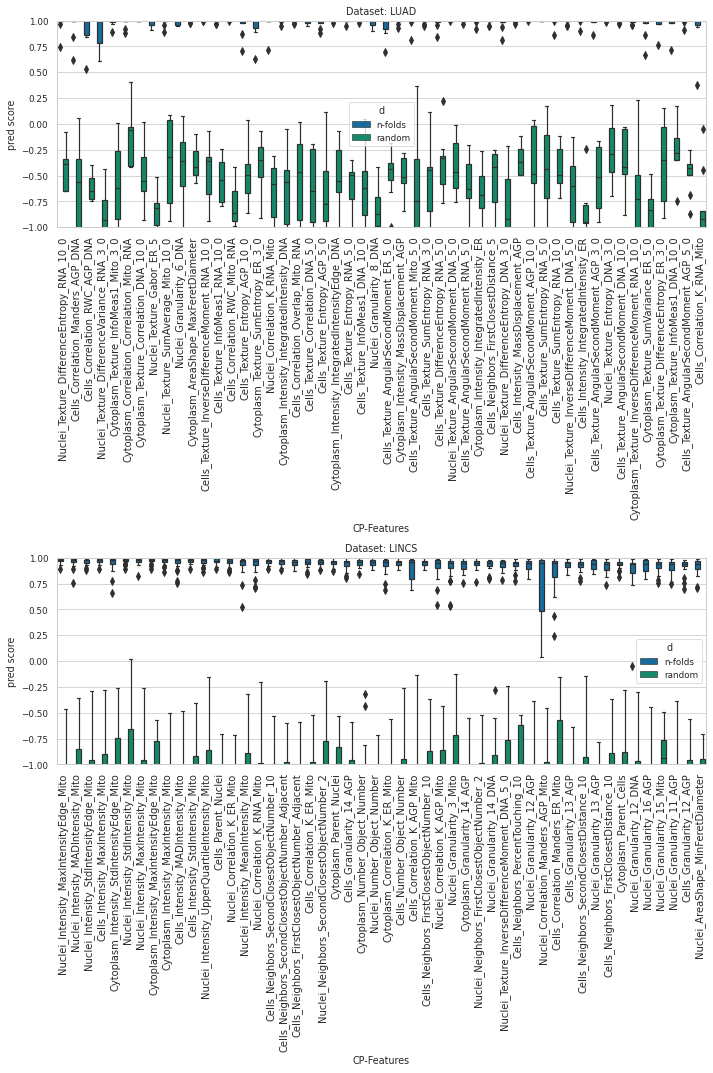

In [57]:
datasets = ["CDRP-bio", "TAORF"]
models = ["MLP"]
f = "-filt"
#'-filt'
DataPredResults_appC = DataPredResults.copy()
fig, axes = plt.subplots(len(datasets), 1, figsize=(10, 15))
sns.set_context("paper")
sns.set_style("whitegrid")
# sns.rcParams['patch.force_edgecolor'] = True
# for d in range(5):#(len(datasets)):
for d in range(len(datasets)):
    for m in range(len(models)):
        dataset_meth_dists = DataPredResults_appC[
            (DataPredResults_appC["Dataset"] == datasets[d])
            & (DataPredResults_appC["Model"] == models[m])
        ]
        #         kjhlhjl
        #         CP-Features
        sorted_gene_mean_scores = (
            dataset_meth_dists[dataset_meth_dists["d"] == "n-folds"]
            .groupby(["CP-Features", "d"])
            .median()
            .reset_index()
            .sort_values(by=["pred score"], ascending=False)
        )
        top_lmGenes = sorted_gene_mean_scores["CP-Features"].tolist()[0:50]
        dataset_meth_dists_top_50 = dataset_meth_dists[
            dataset_meth_dists["CP-Features"].isin(top_lmGenes)
        ]

        #         f, axes = plt.subplots(figsize=(15,4))
        axes[d].set_title("Dataset: " + datasets[d])
        sns.boxplot(
            x="CP-Features",
            y="pred score",
            hue="d",
            data=dataset_meth_dists_top_50,
            ax=axes[d],
            order=top_lmGenes,
        )
        # ax = sns.violinplot(x="lmGens", y="pred score", hue="d",data=tips2, palette="muted", split=True)
        axes[d].set_xticklabels(axes[d].get_xticklabels(), rotation=90, fontsize=10)
        axes[d].set_ylim(-1, 1)

fig.tight_layout()
# fig.savefig('appendix_C1.eps')

datasets = ["LUAD", "LINCS"]
fig, axes = plt.subplots(len(datasets), 1, figsize=(10, 15))
sns.set_context("paper")
sns.set_style("whitegrid")
# sns.rcParams['patch.force_edgecolor'] = True
# for d in range(5):#(len(datasets)):
for d in range(len(datasets)):
    for m in range(len(models)):
        dataset_meth_dists = DataPredResults_appC[
            (DataPredResults_appC["Dataset"] == datasets[d])
            & (DataPredResults_appC["Model"] == models[m])
        ]
        #         kjhlhjl
        #         CP-Features
        sorted_gene_mean_scores = (
            dataset_meth_dists[dataset_meth_dists["d"] == "n-folds"]
            .groupby(["CP-Features", "d"])
            .median()
            .reset_index()
            .sort_values(by=["pred score"], ascending=False)
        )
        top_lmGenes = sorted_gene_mean_scores["CP-Features"].tolist()[0:50]
        dataset_meth_dists_top_50 = dataset_meth_dists[
            dataset_meth_dists["CP-Features"].isin(top_lmGenes)
        ]

        #         f, axes = plt.subplots(figsize=(15,4))
        axes[d].set_title("Dataset: " + datasets[d])
        sns.boxplot(
            x="CP-Features",
            y="pred score",
            hue="d",
            data=dataset_meth_dists_top_50,
            ax=axes[d],
            order=top_lmGenes,
        )
        # ax = sns.violinplot(x="lmGens", y="pred score", hue="d",data=tips2, palette="muted", split=True)
        axes[d].set_xticklabels(axes[d].get_xticklabels(), rotation=90, fontsize=10)
        axes[d].set_ylim(-1, 1)

fig.tight_layout()
# fig.savefig('appendix_C2.eps')

## MoA Cluster retrieval 
- Figure 4a

<IPython.core.display.Javascript object>


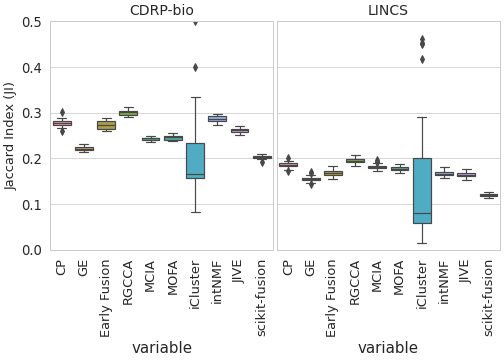

In [739]:
%matplotlib notebook
# res_fig9="~/workspace_rosetta/workspace/software/2021_Haghighi_NeurIPS_Dataset_submitted/results_CP_GE/57/JI.txt"
res_fig9="~/workspace_rosetta/workspace/software/2021_Haghighi_NeurIPS_Dataset_submitted/results_CP_GE_cdrpbio/16/JI.txt"
res_fig9_df=pd.read_csv(res_fig9, sep="\t")
res_fig9_df=res_fig9_df.rename(columns={"concat":'Early Fusion'})
# res_fig9_df.boxplot()

f, axes = plt.subplots(1, 2, sharey=True,figsize=(7,5))
sns.boxplot(x="variable", y="value", data=pd.melt(res_fig9_df),order=['CP', 'GE', 'Early Fusion', 'RGCCA', 'MCIA', 'MOFA', 'iCluster', 'intNMF',
       'JIVE', 'scikit-fusion'],ax=axes[0]);
axes[0].set_xticklabels(axes[0].get_xticklabels(),rotation=90,size=13)
axes[0].set_ylabel("Jaccard Index (JI)", fontsize=13)
axes[0].set_ylim([0,.4]);axes[0].set_title('CDRP-bio');

res_fig9="~/workspace_rosetta/workspace/software/2021_Haghighi_NeurIPS_Dataset_submitted/results_CP_GE_lincs/57/JI.txt"
res_fig9_df=pd.read_csv(res_fig9, sep="\t")
res_fig9_df=res_fig9_df.rename(columns={"concat":'Early Fusion'})
# res_fig9_df.boxplot()

sns.boxplot(x="variable", y="value", data=pd.melt(res_fig9_df),order=['CP', 'GE', 'Early Fusion', 'RGCCA', 'MCIA', 'MOFA', 'iCluster', 'intNMF',
       'JIVE', 'scikit-fusion'],ax=axes[1]);
axes[1].set_xticklabels(axes[1].get_xticklabels(),rotation=90,size=13)
axes[1].set(ylabel=None)
# axes[1].set_ylabel("Jaccard Index (JI)", fontsize=11)
axes[1].set_ylim([0,.5]);axes[1].set_title('LINCS');

plt.tight_layout()

In [714]:
# res_fig9_df
# res_fig9_df

In [713]:
# * Statistical tests for differences in the features across groups
from scipy import stats

all_t = list()
all_p = list()

g1 = res_fig9_df["CP"].values
for di in res_fig9_df.columns:
    g2 = res_fig9_df[di].values
    t, p = stats.ttest_ind(g1, g2)
    all_t.append(t)
    all_p.append(p)
all_p

[1.0,
 7.21770326111321e-56,
 2.4162659422082057e-31,
 2.5331992827659195e-16,
 2.692274469891824e-06,
 5.535029367914641e-13,
 0.13282283398955777,
 1.7853630817644763e-40,
 3.774923536992018e-102,
 3.557241284692935e-38]

<IPython.core.display.Javascript object>


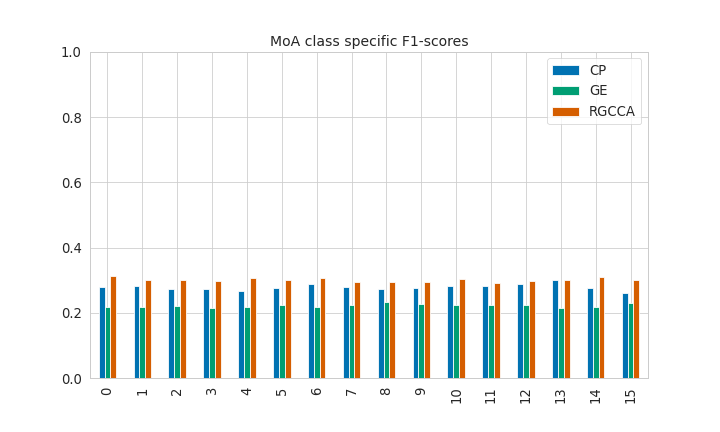

(0.0, 1.0)

In [722]:
report_clss4 = res_fig9_df[["CP", "GE", "RGCCA"]]
# report_clss4.index=report_clss3['MoA']
ax = report_clss4.plot.bar(rot=90, figsize=(10, 6))
plt.title("MoA class specific F1-scores")
ax.set_ylim([0, 1])
